# t-SNE Explorations

In [173]:
%matplotlib notebook

import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import sqlite3
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
from   sklearn.decomposition import PCA
from   sklearn.manifold import TSNE, Isomap, LocallyLinearEmbedding, MDS, SpectralEmbedding
from   sklearn.preprocessing import StandardScaler

np.set_printoptions(suppress=True)
np.set_printoptions(precision=4)
plt_style = 'seaborn-talk'

# Experimental: HDBScan is a state-of-the-art clustering algorithm
hdbscan_available = True
try:
    import hdbscan
except ImportError:
    hdbscan_available = False

In [174]:
conn = sqlite3.connect('../../livs.db')  # Create db and establish connection
conn.row_factory = sqlite3.Row
curs = conn.cursor()
result = []
rows = curs.execute('select * from livs where Huvudgrupp = "Grönsaker" OR Huvudgrupp = "Sås dressing majonnäs"')
for row in rows:
        result.append(row)

db_contents = np.array(result)

conn.close()

In [175]:
data = db_contents[0:2000,2:5]
data.shape

labels = db_contents[0:2000,60]
labels

array(['Sås dressing majonnäs', 'Sås dressing majonnäs',
       'Sås dressing majonnäs', 'Sås dressing majonnäs',
       'Sås dressing majonnäs', 'Sås dressing majonnäs',
       'Sås dressing majonnäs', 'Sås dressing majonnäs',
       'Sås dressing majonnäs', 'Sås dressing majonnäs',
       'Sås dressing majonnäs', 'Sås dressing majonnäs',
       'Sås dressing majonnäs', 'Sås dressing majonnäs',
       'Sås dressing majonnäs', 'Sås dressing majonnäs',
       'Sås dressing majonnäs', 'Sås dressing majonnäs',
       'Sås dressing majonnäs', 'Sås dressing majonnäs',
       'Sås dressing majonnäs', 'Sås dressing majonnäs', 'Grönsaker',
       'Grönsaker', 'Grönsaker', 'Grönsaker', 'Grönsaker', 'Grönsaker',
       'Grönsaker', 'Grönsaker', 'Grönsaker', 'Grönsaker', 'Grönsaker',
       'Grönsaker', 'Grönsaker', 'Grönsaker', 'Grönsaker', 'Grönsaker',
       'Grönsaker', 'Grönsaker', 'Grönsaker', 'Grönsaker', 'Grönsaker',
       'Grönsaker', 'Grönsaker', 'Grönsaker', 'Grönsaker', 'Grönsaker',


## Plotting function

In [69]:
def do_plot(X_fit, labels, title=None):
    dimension = X_fit.shape[1]
    label_types = sorted(list(set(labels)))
    num_labels = len(label_types)
    colors = cm.Accent(np.linspace(0, 1, num_labels))
    with plt.style.context(plt_style):
        fig = plt.figure()
        if dimension == 2:
            ax = fig.add_subplot(111)
            for lab, col in zip(label_types, colors):
                ax.scatter(X_fit[labels==lab, 0],
                           X_fit[labels==lab, 1],
                           c=col)
        elif dimension == 3:
            ax = fig.add_subplot(111, projection='3d')
            for lab, col in zip(label_types, colors):
                ax.scatter(X_fit[labels==lab, 0],
                           X_fit[labels==lab, 1],
                           X_fit[labels==lab, 2],
                           c=col)
        else:
            raise Exception('Unknown dimension: %d' % dimension)
        plt.title(title)
        plt.show()

## Generate the data
To create a simple test case, we generate some Gaussian point clouds in $\mathbb{R}^3$. Then we see how they look embedded in $\mathbb{R}^2$ and $\mathbb{R}^3$ using various algorithms, including t-SNE.

There's one point cloud centered at the origin and three on each of the three axes. They are well separated, as can be seen in the first visualization below.

In [63]:
num_dimensions = 3 #Gjort endast för 3D...
num_clusters = 4
num_points = 100
cluster_separation = 6
centers = np.array([(0,0,0), (1,0,0), (0,1,0), (0,0,1)], dtype=float) * cluster_separation
data = np.zeros((num_clusters * num_points, num_dimensions), dtype=float)
labels = np.zeros(num_clusters * num_points, dtype=int)
for c in range(num_clusters):
    start = c * num_points
    end = start + num_points
    data[start:end, :] = np.random.randn(num_points, num_dimensions) + centers[c]
    labels[start:end] = c

In [176]:
data_df = pd.DataFrame(data, columns=('x','y','z'))
data_df['label'] = labels
data_df.head()

,x,y,z,label
0,784.3,3281.5,0.41,Sås dressing majonnäs
1,383.9,1606.3,3.92,Sås dressing majonnäs
2,435.3,1821.2,12.33,Sås dressing majonnäs
3,554.9,2321.9,13.1,Sås dressing majonnäs
4,707.7,2960.9,1.07,Sås dressing majonnäs


In [177]:
data.shape

(173, 3)

In [178]:
labels

array(['Sås dressing majonnäs', 'Sås dressing majonnäs',
       'Sås dressing majonnäs', 'Sås dressing majonnäs',
       'Sås dressing majonnäs', 'Sås dressing majonnäs',
       'Sås dressing majonnäs', 'Sås dressing majonnäs',
       'Sås dressing majonnäs', 'Sås dressing majonnäs',
       'Sås dressing majonnäs', 'Sås dressing majonnäs',
       'Sås dressing majonnäs', 'Sås dressing majonnäs',
       'Sås dressing majonnäs', 'Sås dressing majonnäs',
       'Sås dressing majonnäs', 'Sås dressing majonnäs',
       'Sås dressing majonnäs', 'Sås dressing majonnäs',
       'Sås dressing majonnäs', 'Sås dressing majonnäs', 'Grönsaker',
       'Grönsaker', 'Grönsaker', 'Grönsaker', 'Grönsaker', 'Grönsaker',
       'Grönsaker', 'Grönsaker', 'Grönsaker', 'Grönsaker', 'Grönsaker',
       'Grönsaker', 'Grönsaker', 'Grönsaker', 'Grönsaker', 'Grönsaker',
       'Grönsaker', 'Grönsaker', 'Grönsaker', 'Grönsaker', 'Grönsaker',
       'Grönsaker', 'Grönsaker', 'Grönsaker', 'Grönsaker', 'Grönsaker',


## Prep the data for fitting and visualizing

In [179]:
X = data_df.iloc[:,0:-1]
X_std = StandardScaler().fit_transform(X)
y = data_df['label'].values

In [180]:
X.values

array([['784.3', '3281.5', '0.41'],
       ['383.9', '1606.3', '3.92'],
       ['435.3', '1821.2', '12.33'],
       ['554.9', '2321.9', '13.1'],
       ['707.7', '2960.9', '1.07'],
       ['438.4', '1834.4', '3.32'],
       ['262.5', '1098.4', '9.7'],
       ['572.4', '2394.8', '9.5'],
       ['453.6', '1898.1', '24.0'],
       ['303.1', '1268.4', '19.7'],
       ['415.7', '1739.2', '8.0'],
       ['303.9', '1271.5', '15.0'],
       ['216.8', '907.1', '20.8'],
       ['59.7', '249.9', '13.1'],
       ['717.6', '3002.5', '1.5'],
       ['326.8', '1367.4', '8.5'],
       ['496.3', '2076.4', '1.18'],
       ['552.4', '2311.0', '0.45'],
       ['359.5', '1504.0', '6.39'],
       ['586.2', '2452.6', '2.2'],
       ['223.5', '935.1', '6.7'],
       ['231.9', '970.4', '6.6'],
       ['197.2', '825.1', '1.7'],
       ['13.3', '55.5', '1.5'],
       ['24.4', '102.1', '2.6'],
       ['23.8', '99.4', '2.3'],
       ['35.2', '147.3', '3.12'],
       ['24.0', '100.4', '1.8'],
       ['43.6', '182.4

In [181]:
X_fit = X
labels = y
title=None
dimension = X_fit.shape[1]
dimension

3

In [182]:
label_types = np.array(sorted(list(set(labels))))
num_labels = len(label_types)
colors = cm.Accent(np.linspace(0, 1, num_labels))
label_types

array(['Grönsaker', 'Sås dressing majonnäs'],
      dtype='<U21')

In [183]:
#Gör om text-labels till löpnummer för kategorin
for index, label in enumerate(labels):
    ind = np.where(label==label_types)
    labels[index] = ind[0][0]

In [184]:
labels

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], dtype=object)

In [185]:
list(labels)

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1]

<IPython.core.display.Javascript object>


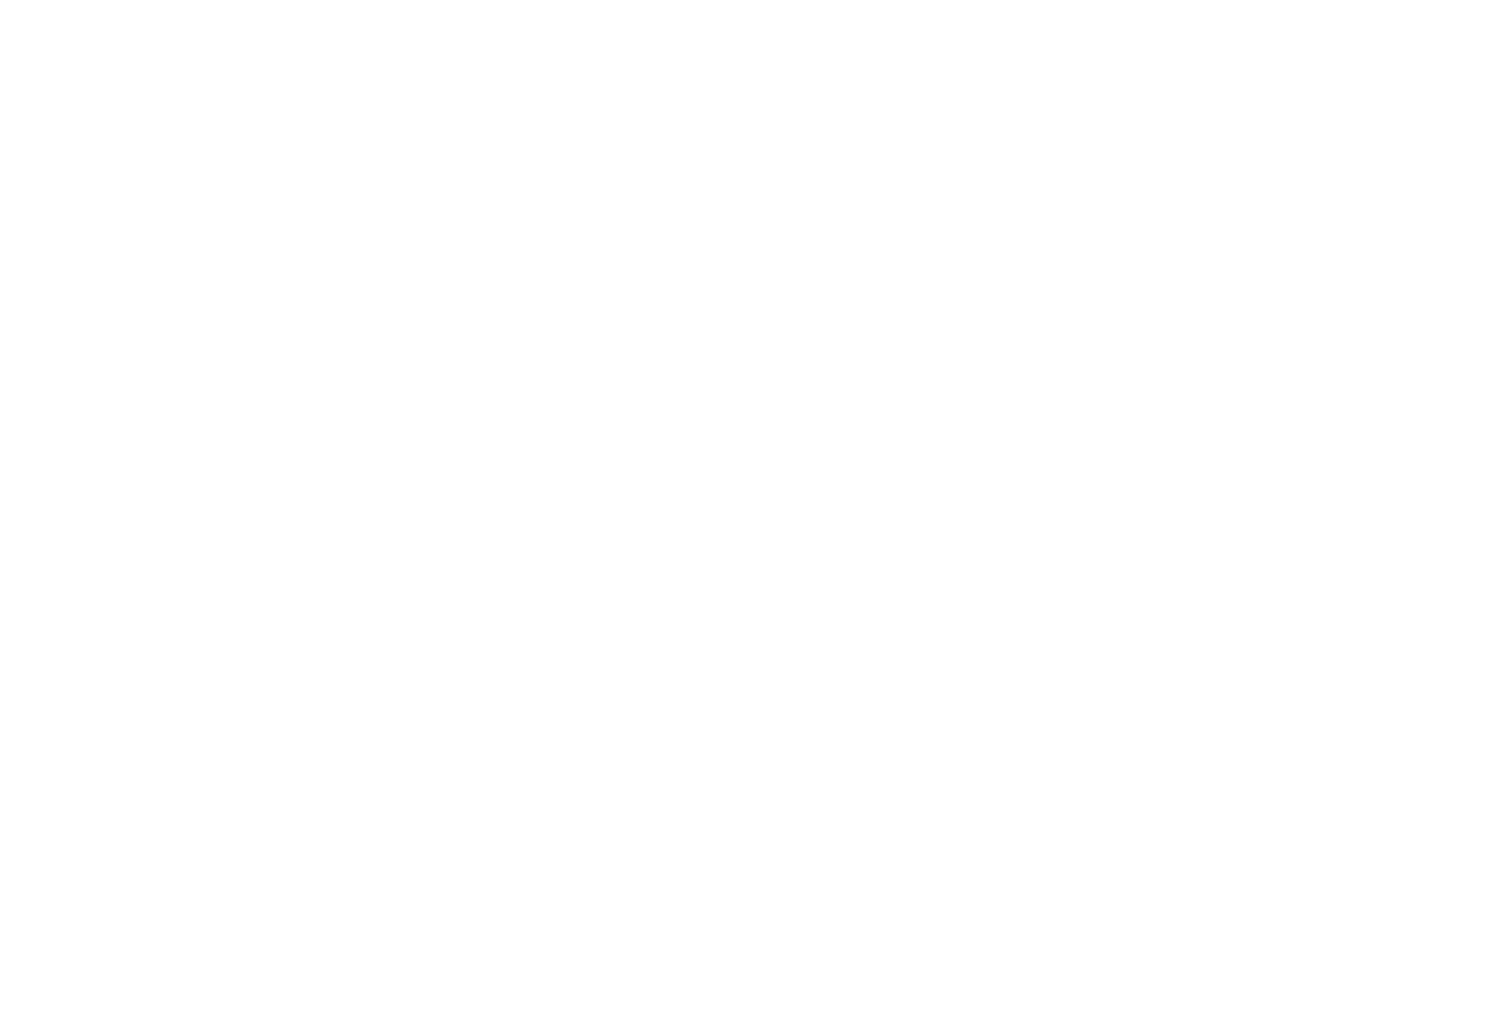

TypeError: unhashable type: 'numpy.ndarray'

<IPython.core.display.Javascript object>


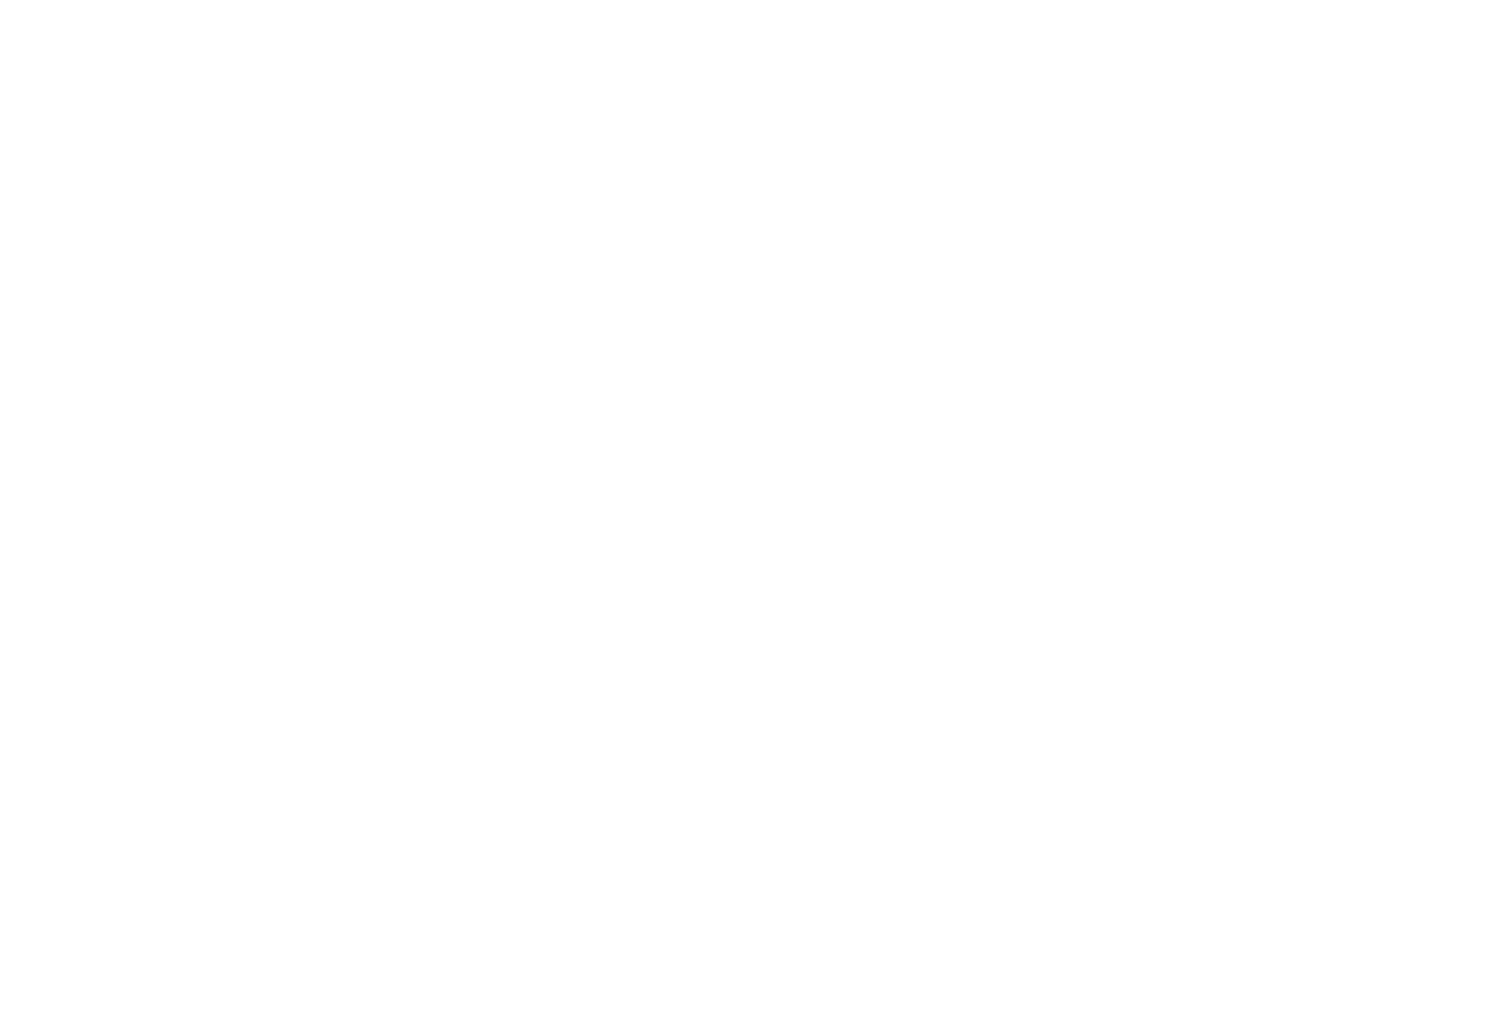

In [186]:
with plt.style.context(plt_style):
    fig = plt.figure()
    if dimension == 2:
        ax = fig.add_subplot(111)
        for lab, col in zip(label_types, colors):
            ax.scatter(X_fit[labels==lab, 0],
                       X_fit[labels==lab, 1],
                       c=col)
    elif dimension == 3:
        ax = fig.add_subplot(111, projection='3d')
        for lab, col in zip(label_types, colors):
            ax.scatter(X_fit[labels==lab, 0],
                       X_fit[labels==lab, 1],
                       X_fit[labels==lab, 2],
                       c=col)
    else:
        raise Exception('Unknown dimension: %d' % dimension)
    plt.title(title)
    plt.show()

## 3D view

<IPython.core.display.Javascript object>


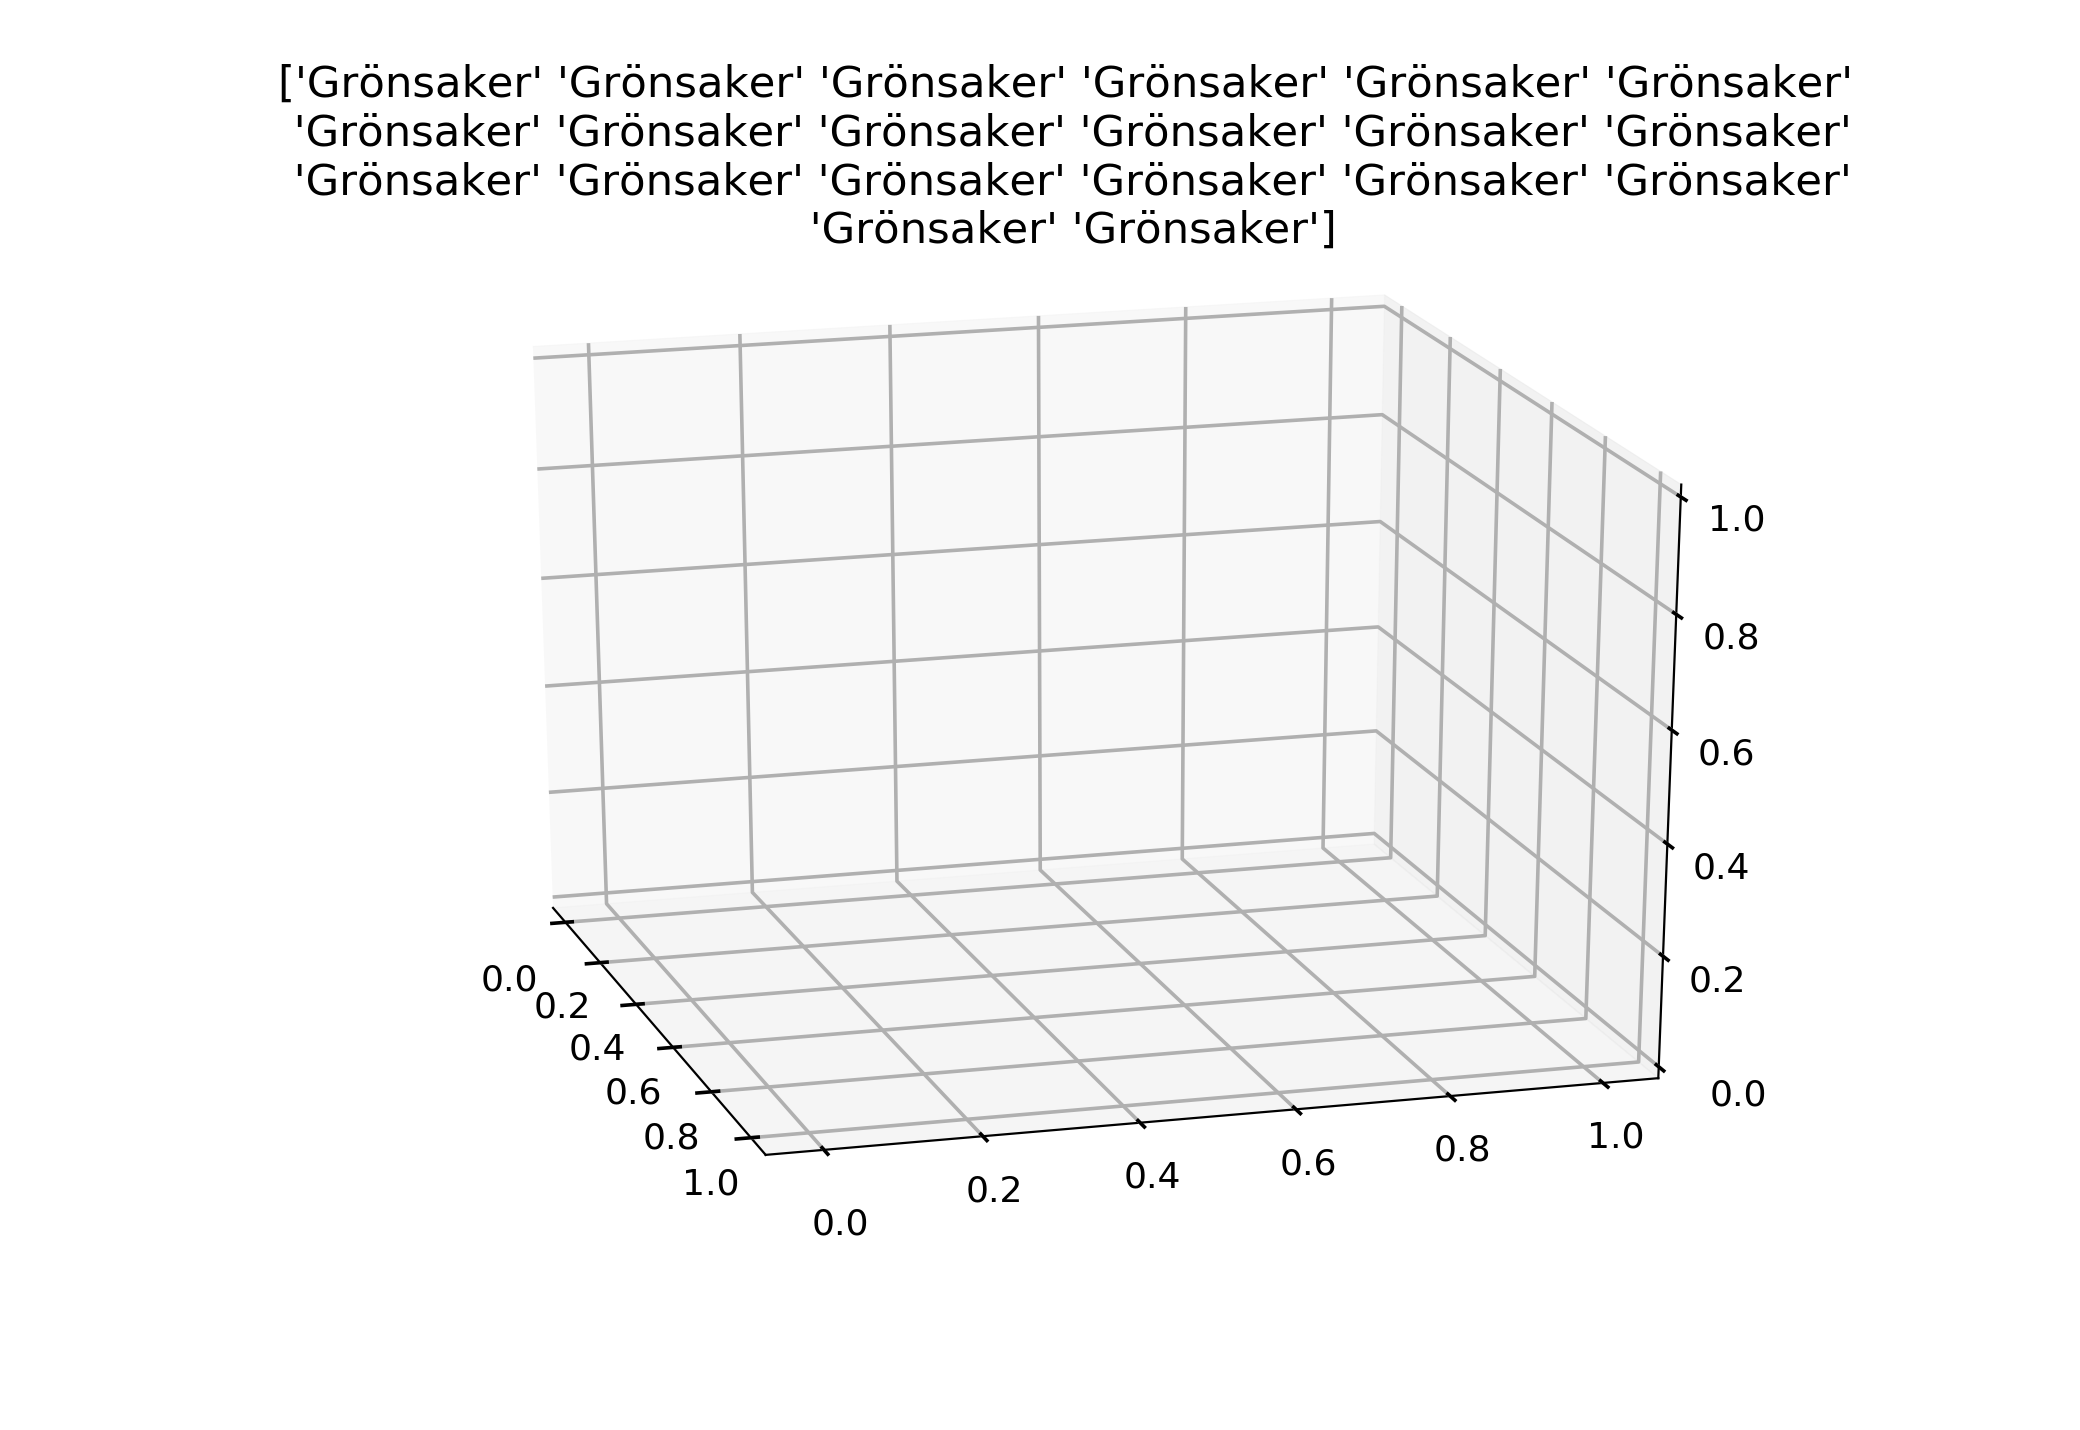

In [75]:
do_plot(X.values, 'Original Data',labels)

In [76]:
X.values[:,0:-1].shape

(20, 2)

## Dumb 2D projection
The easiest way to embed our data into two dimensions is to project onto the plane $x=0$.

In [78]:

X.values[:,1:]

array([['825.1', '1.7'],
       ['55.5', '1.5'],
       ['102.1', '2.6'],
       ['99.4', '2.3'],
       ['147.3', '3.12'],
       ['100.4', '1.8'],
       ['182.4', '4.7'],
       ['173.2', '3.4'],
       ['62.4', '1.0'],
       ['57.0', '1.1'],
       ['119.4', '1.8'],
       ['167.4', '3.2'],
       ['124.3', '2.3'],
       ['54.8', '2.3'],
       ['60.7', '2.5'],
       ['217.4', '7.3'],
       ['121.8', '4.4'],
       ['163.1', '7.3'],
       ['523.7', '22.07'],
       ['465.6', '21.5']], dtype=object)

<IPython.core.display.Javascript object>


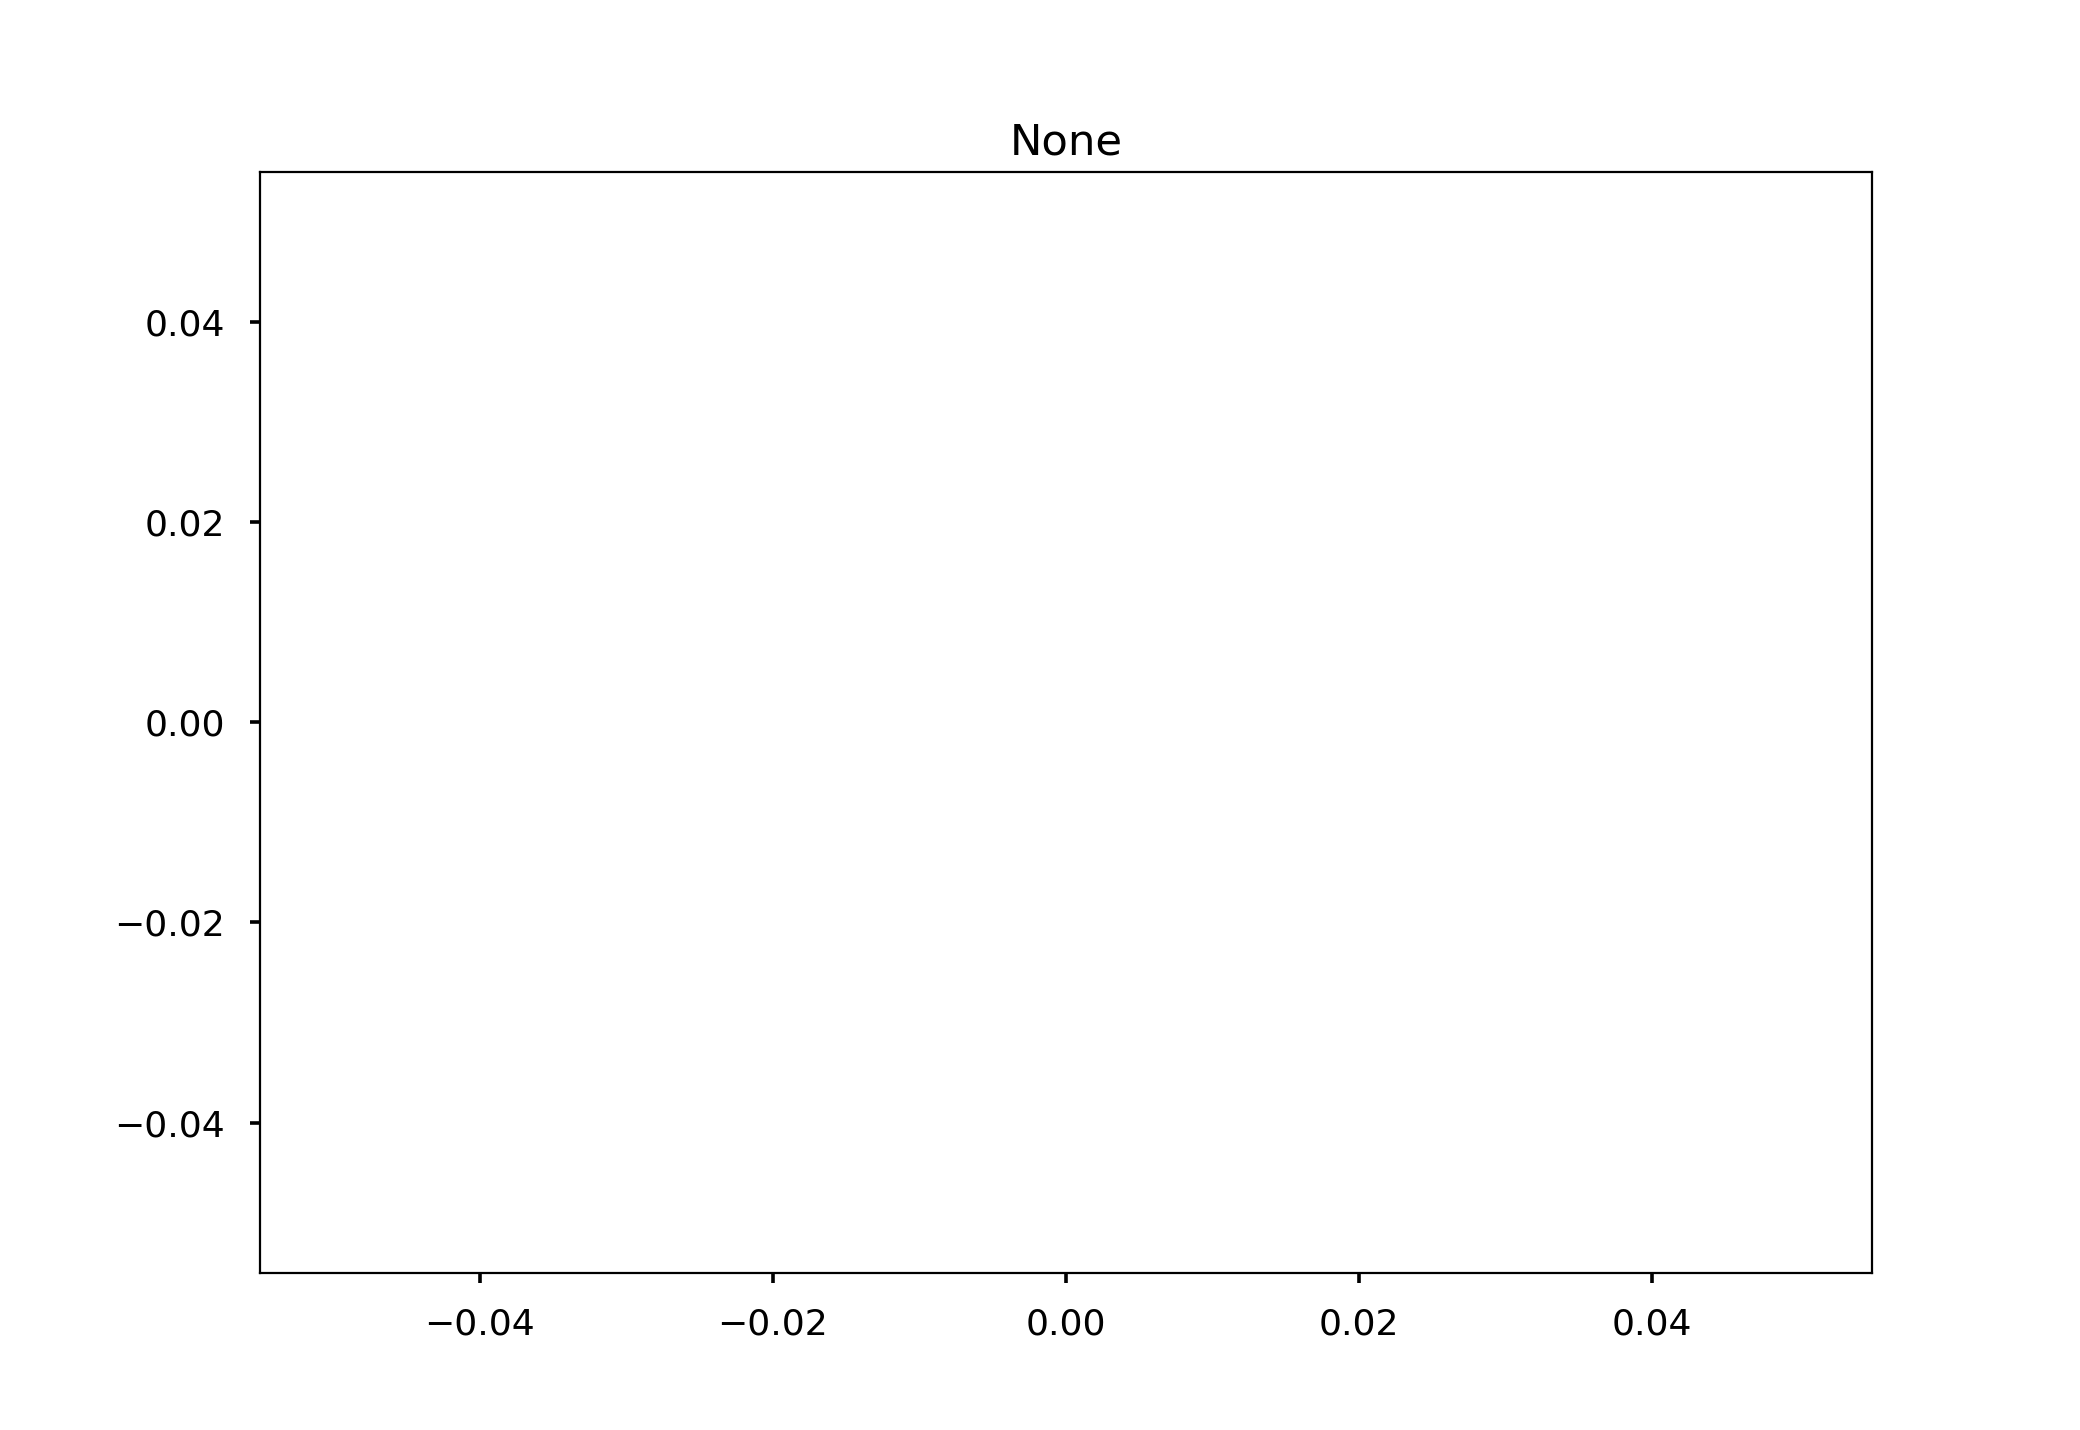

In [77]:
do_plot(X.values[:,1:], 'Plane $x=0$')

## PCA (2D)

<IPython.core.display.Javascript object>


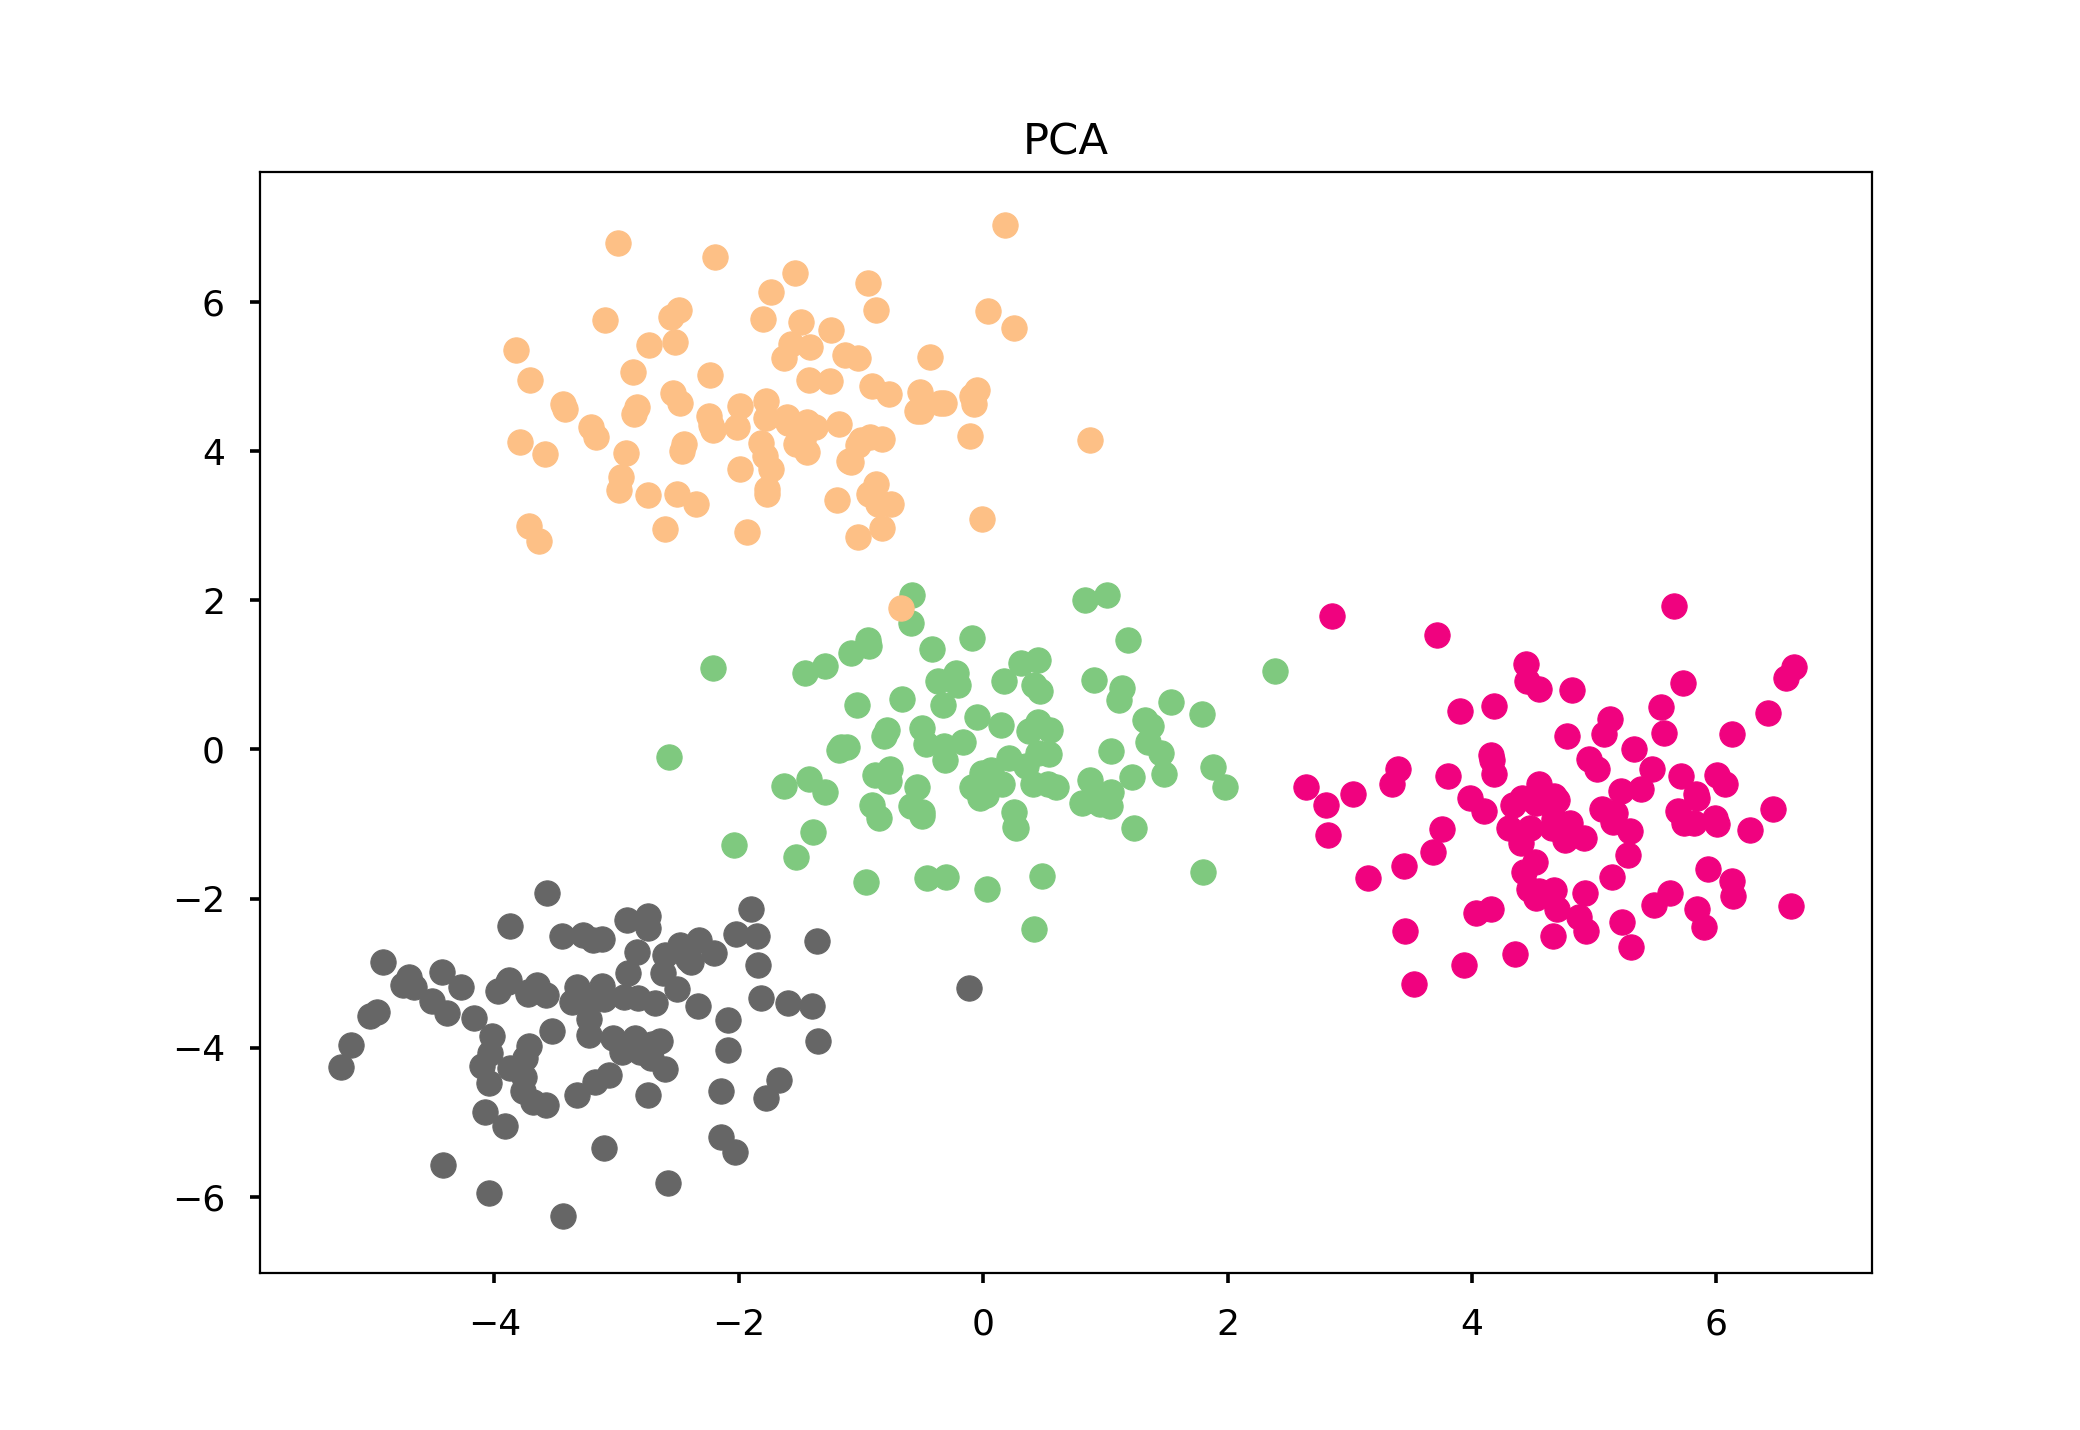

In [13]:
do_plot(PCA(n_components=2).fit_transform(X), 'PCA')

## Isomap

<IPython.core.display.Javascript object>


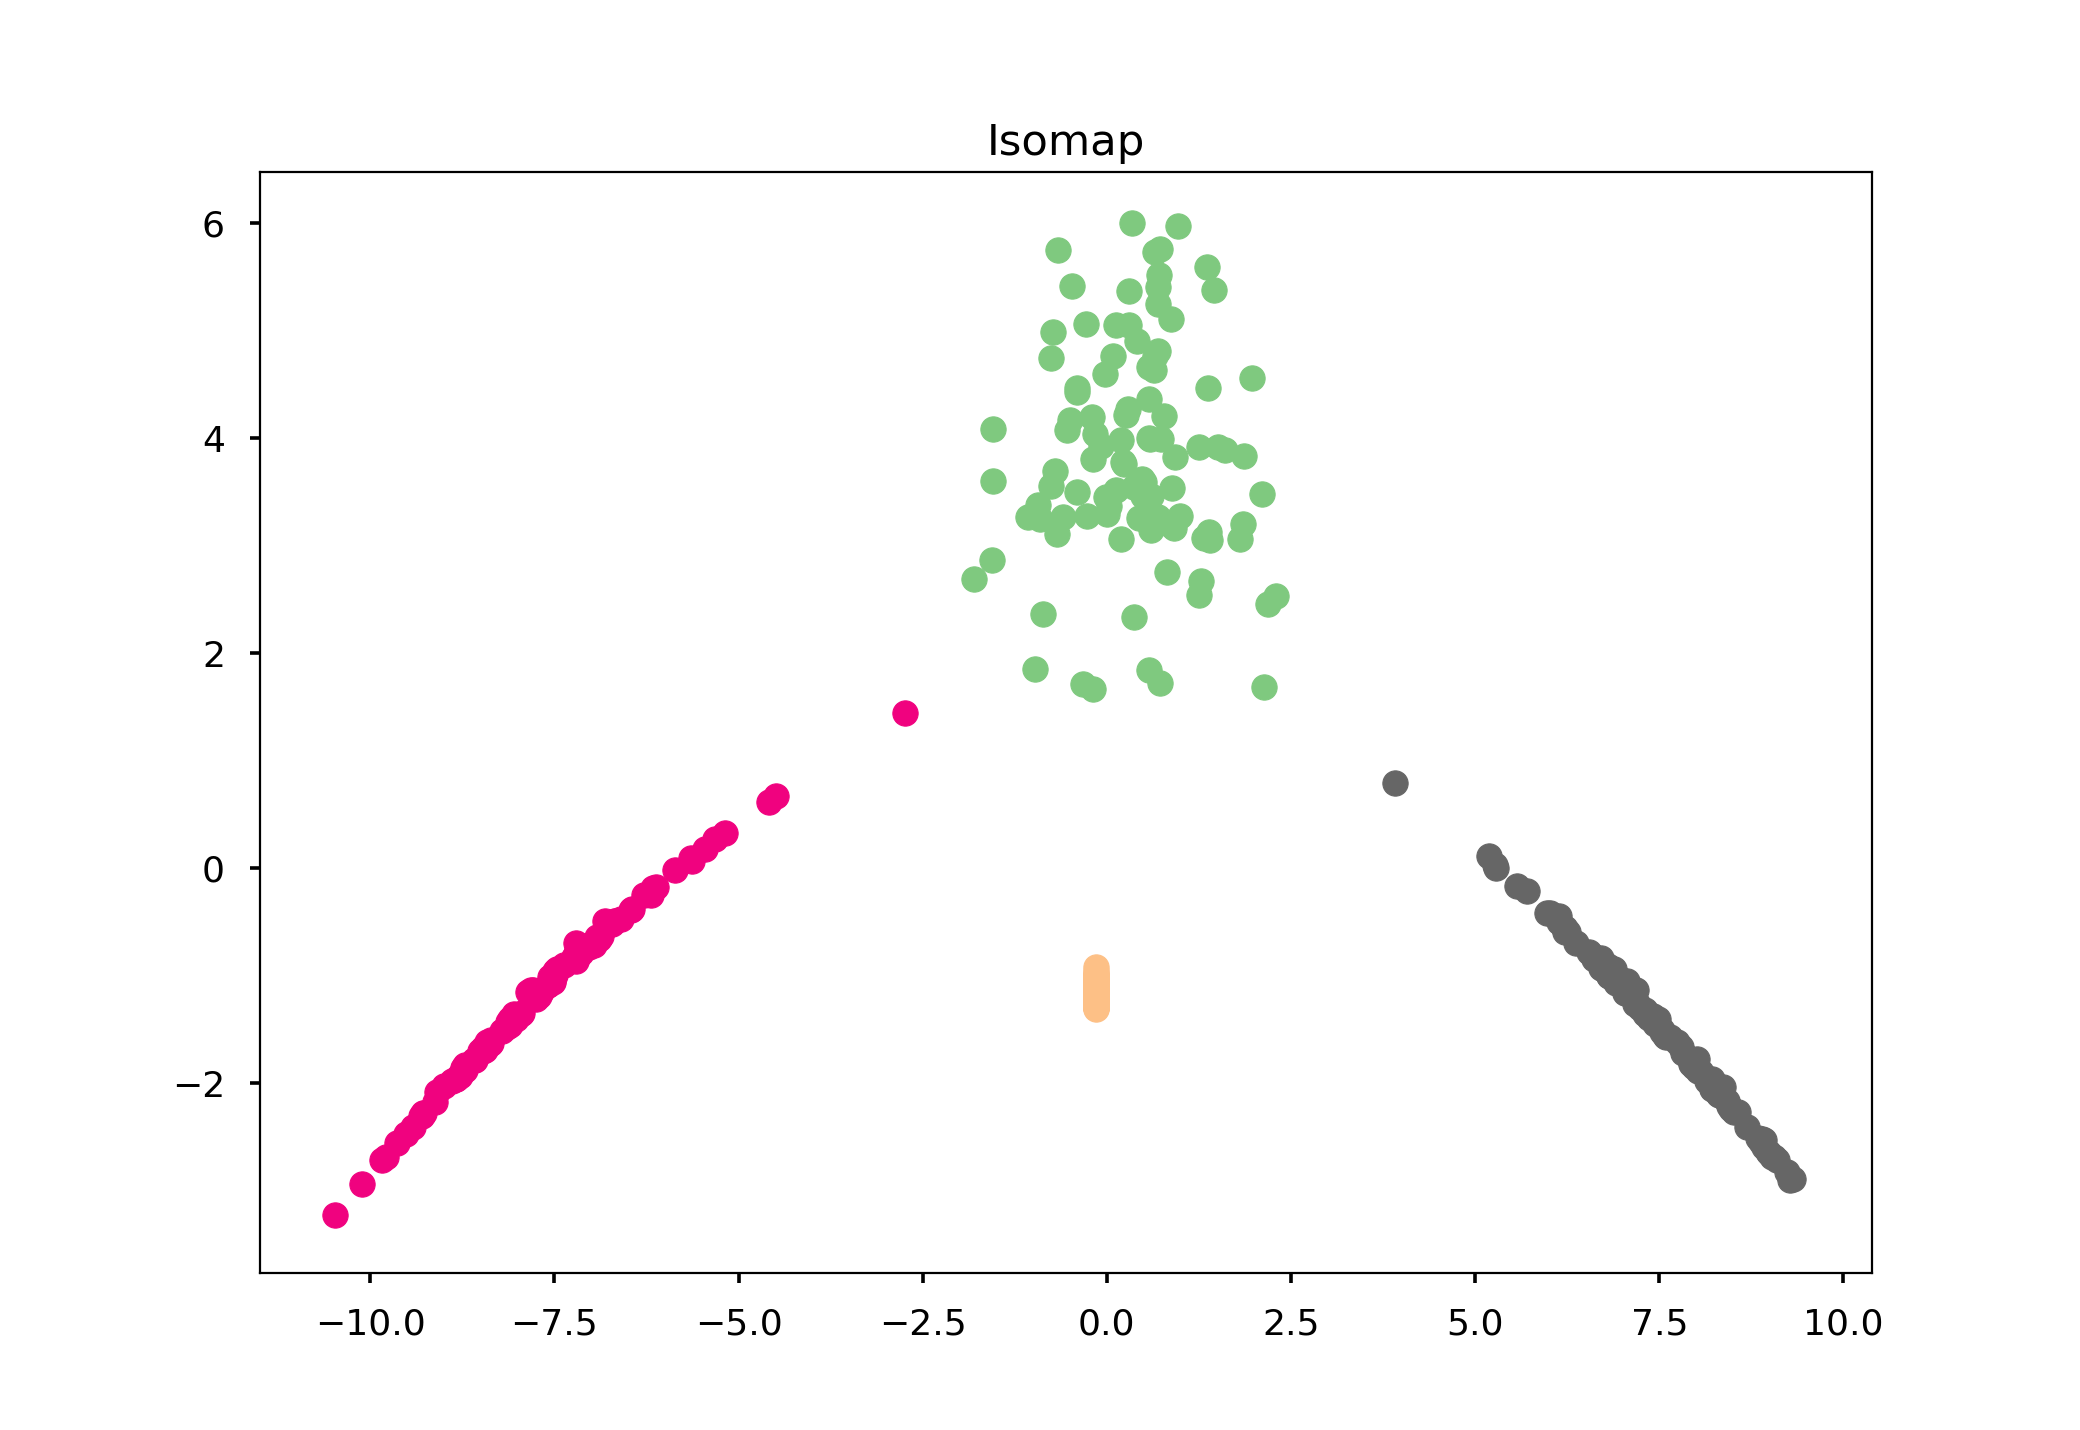

In [14]:
do_plot(Isomap(n_components=2).fit_transform(X), 'Isomap')

## Locally Linear Embedding

<IPython.core.display.Javascript object>


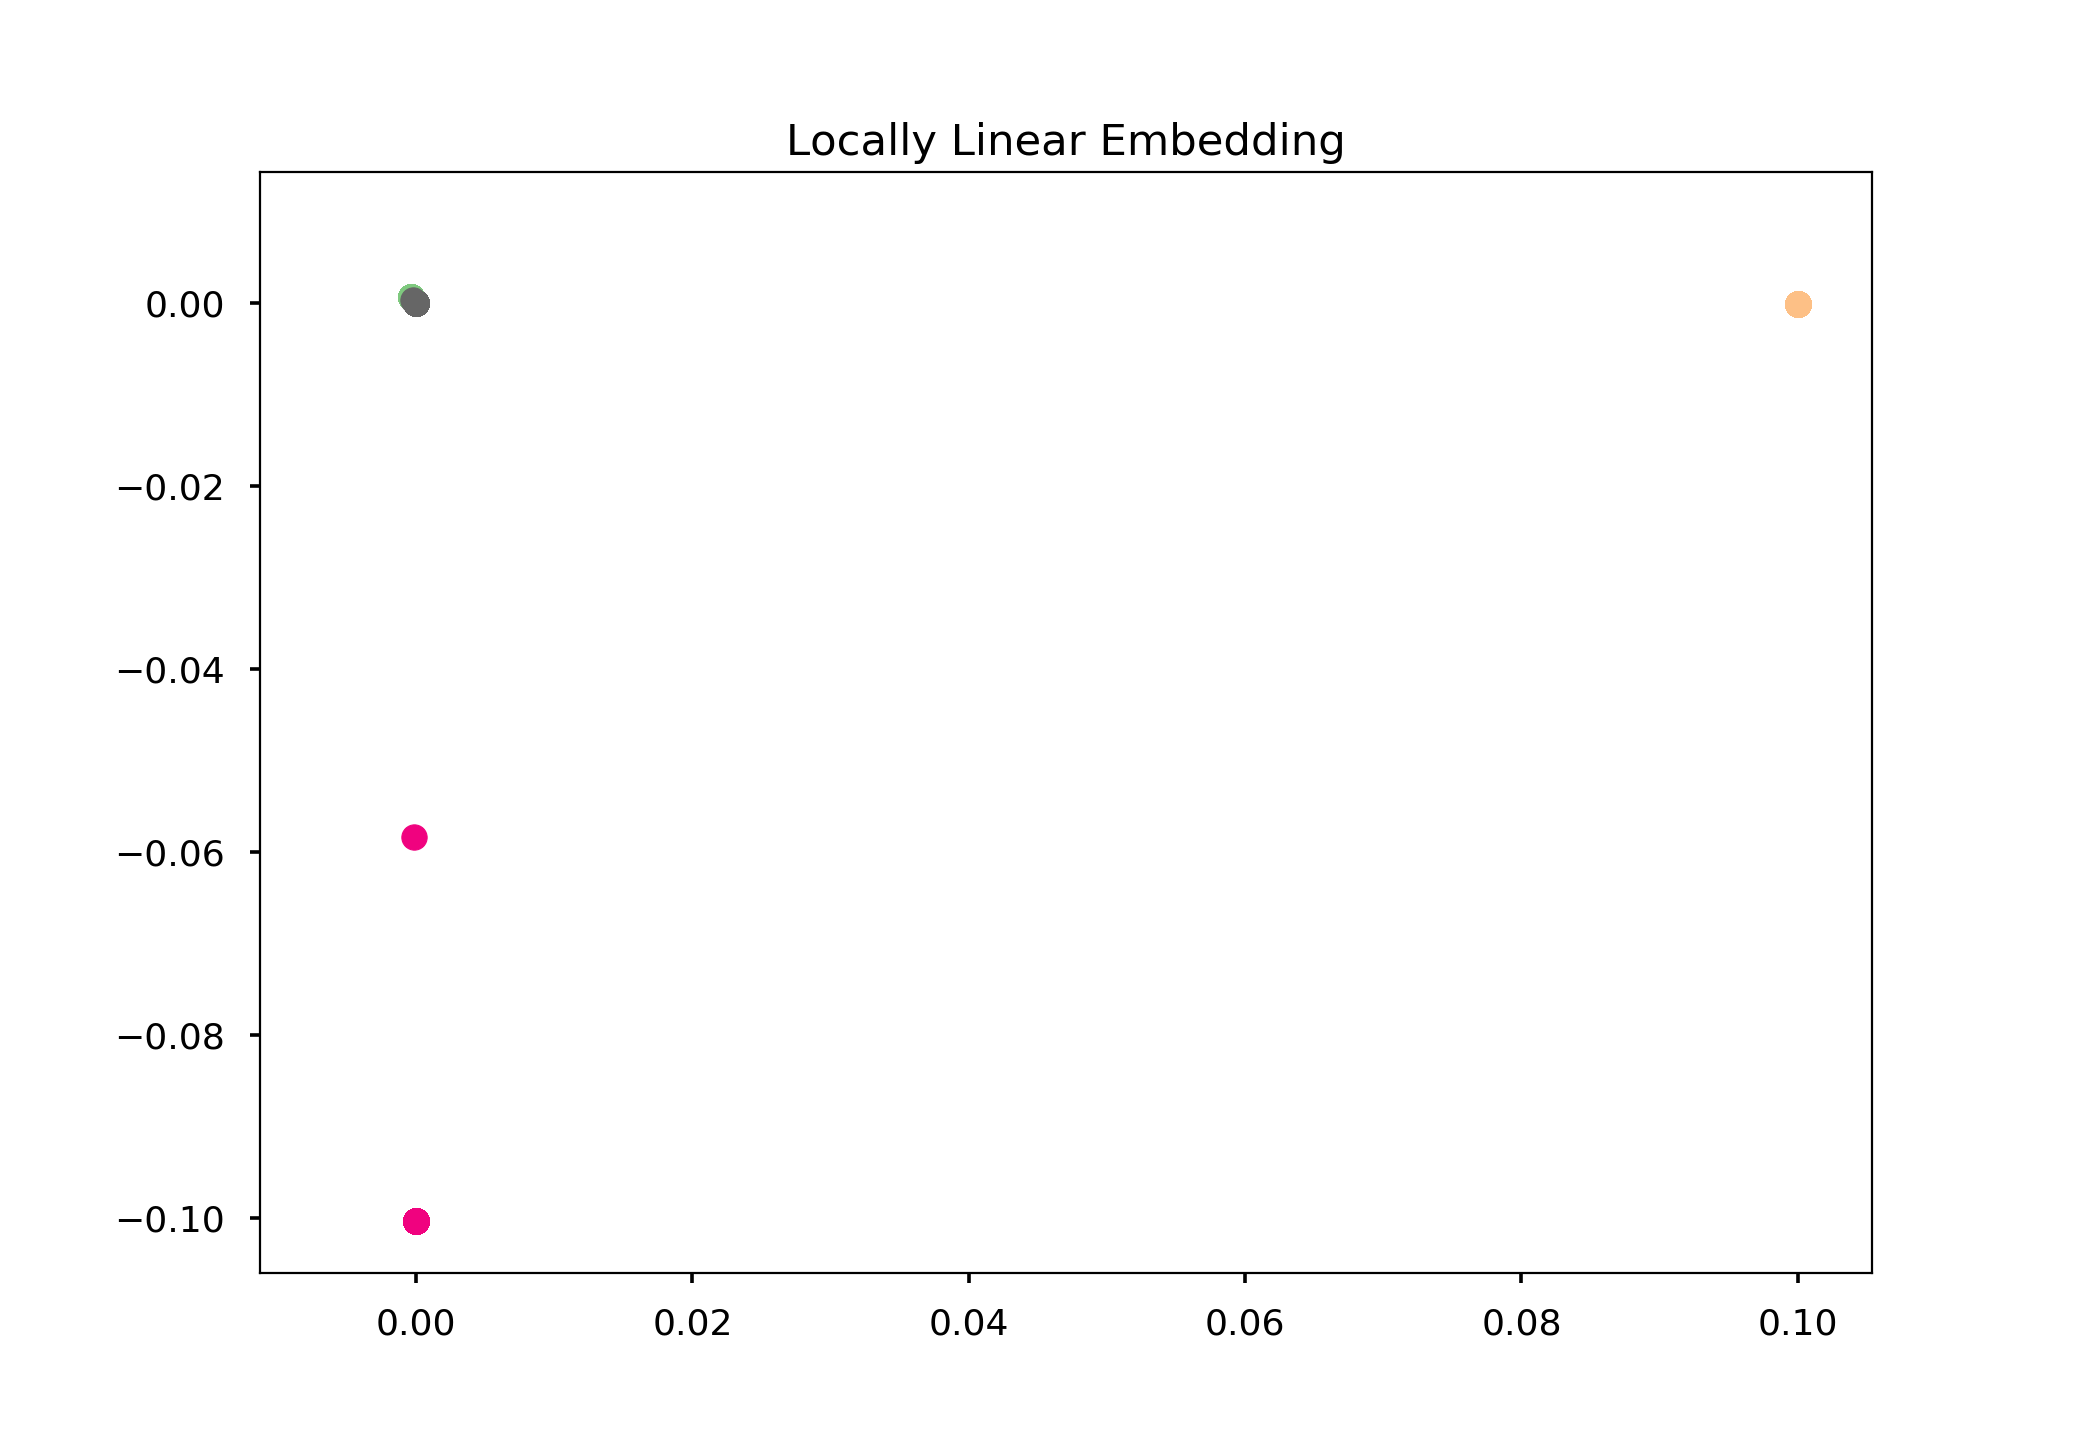

In [15]:
do_plot(LocallyLinearEmbedding(n_components=2).fit_transform(X), 'Locally Linear Embedding')

## Spectral Embedding

<IPython.core.display.Javascript object>


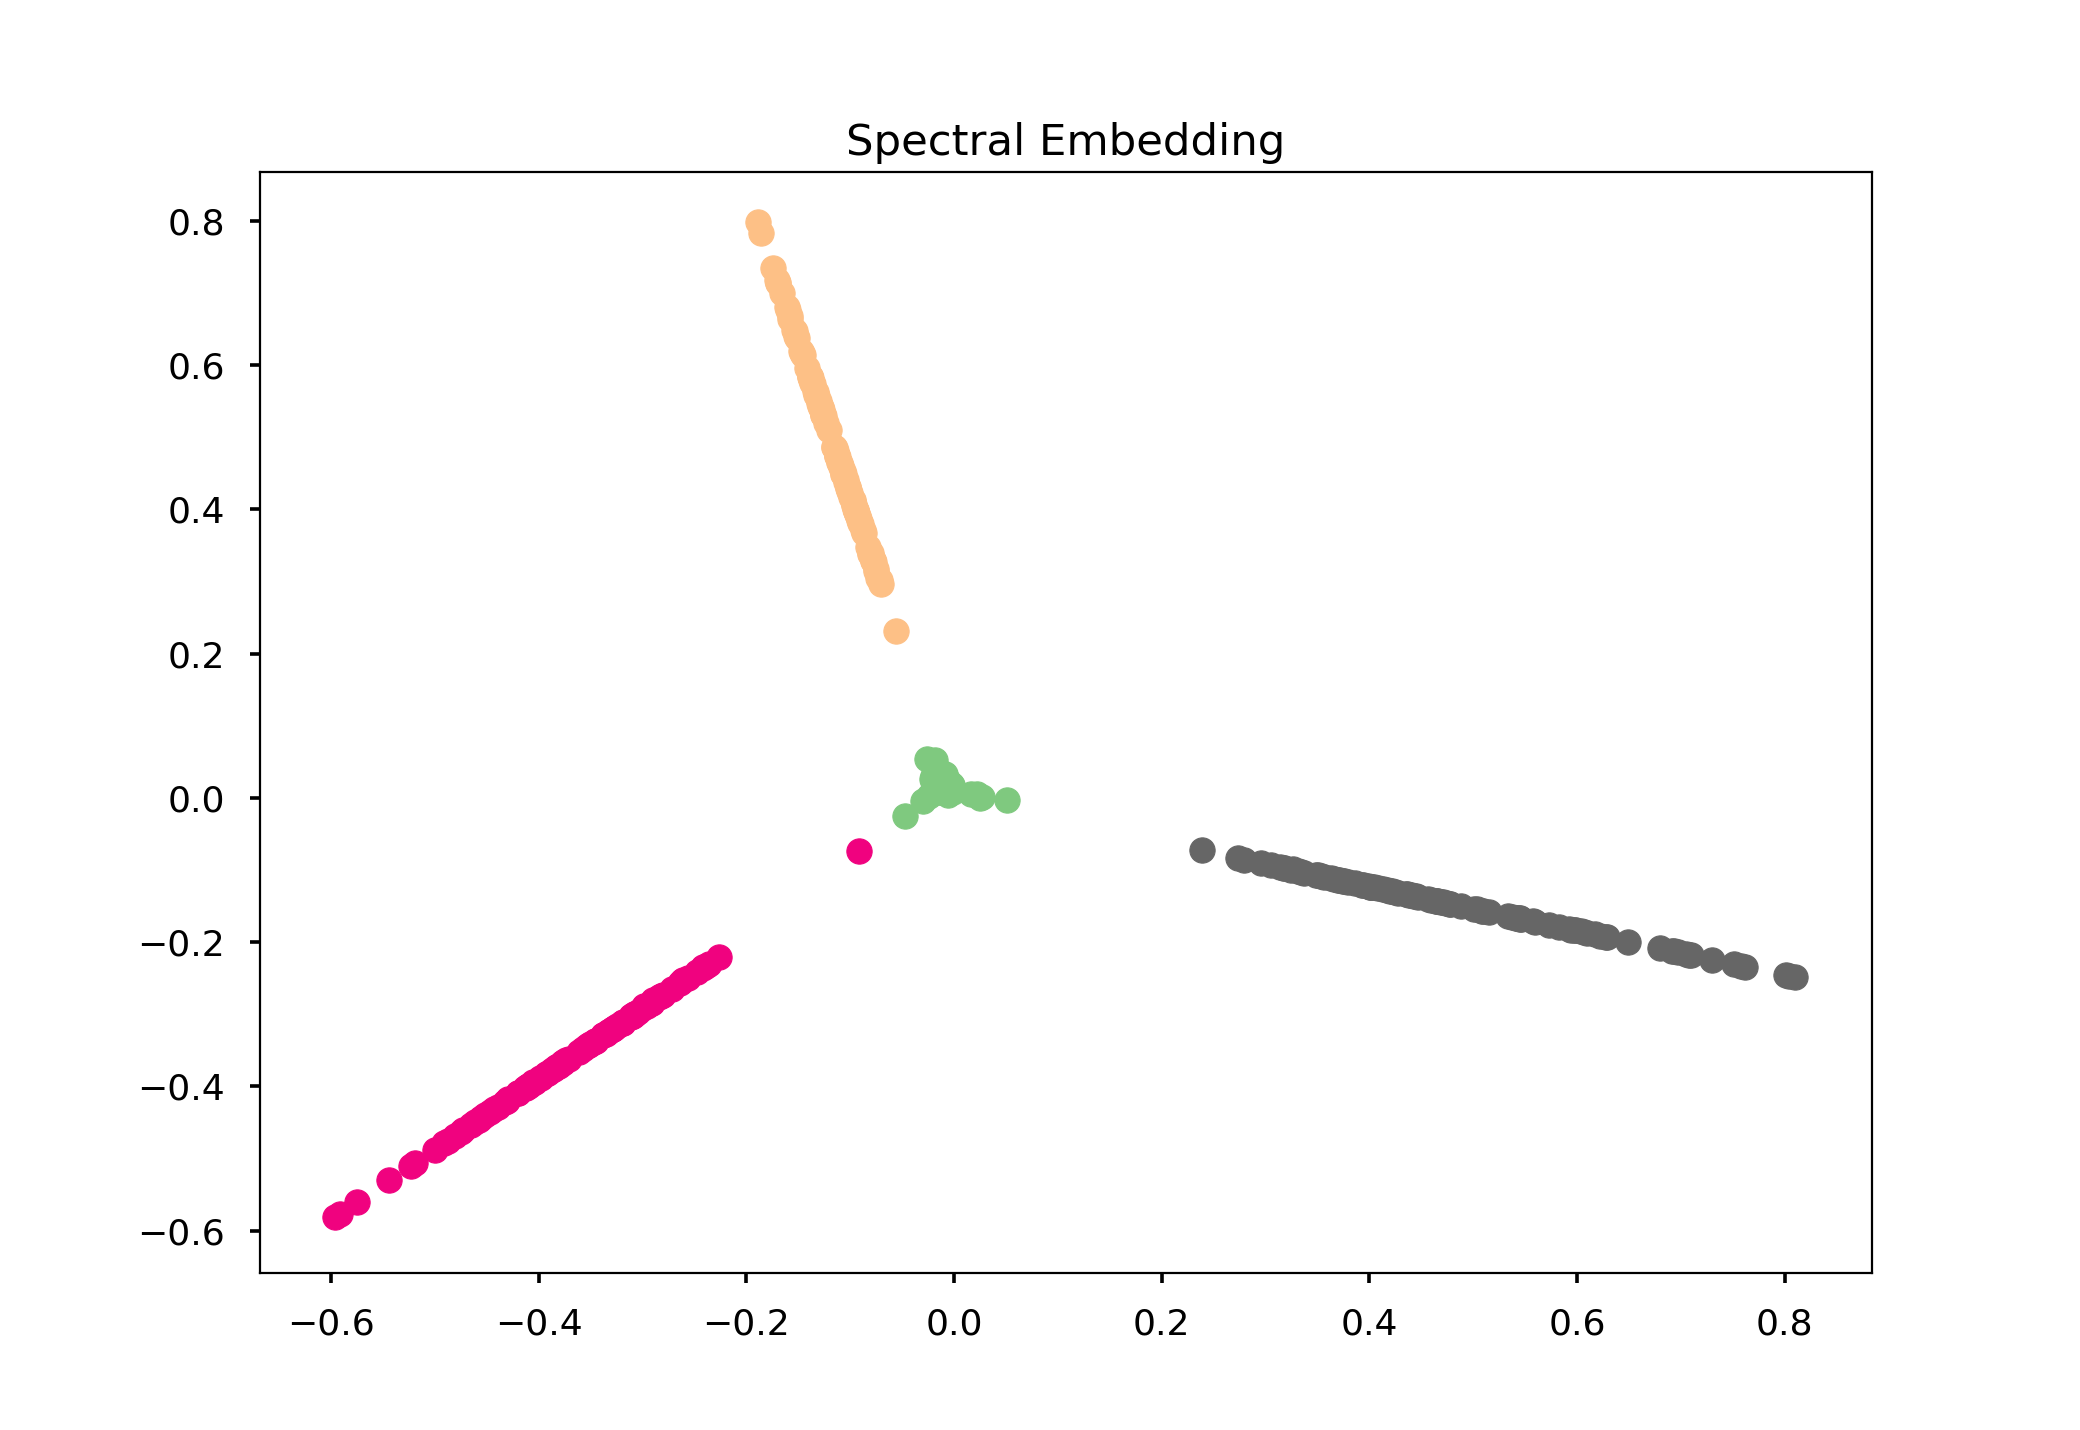

In [16]:
do_plot(SpectralEmbedding(n_components=2).fit_transform(X), 'Spectral Embedding')

## Multi-dimensional scaling (MDS)

<IPython.core.display.Javascript object>


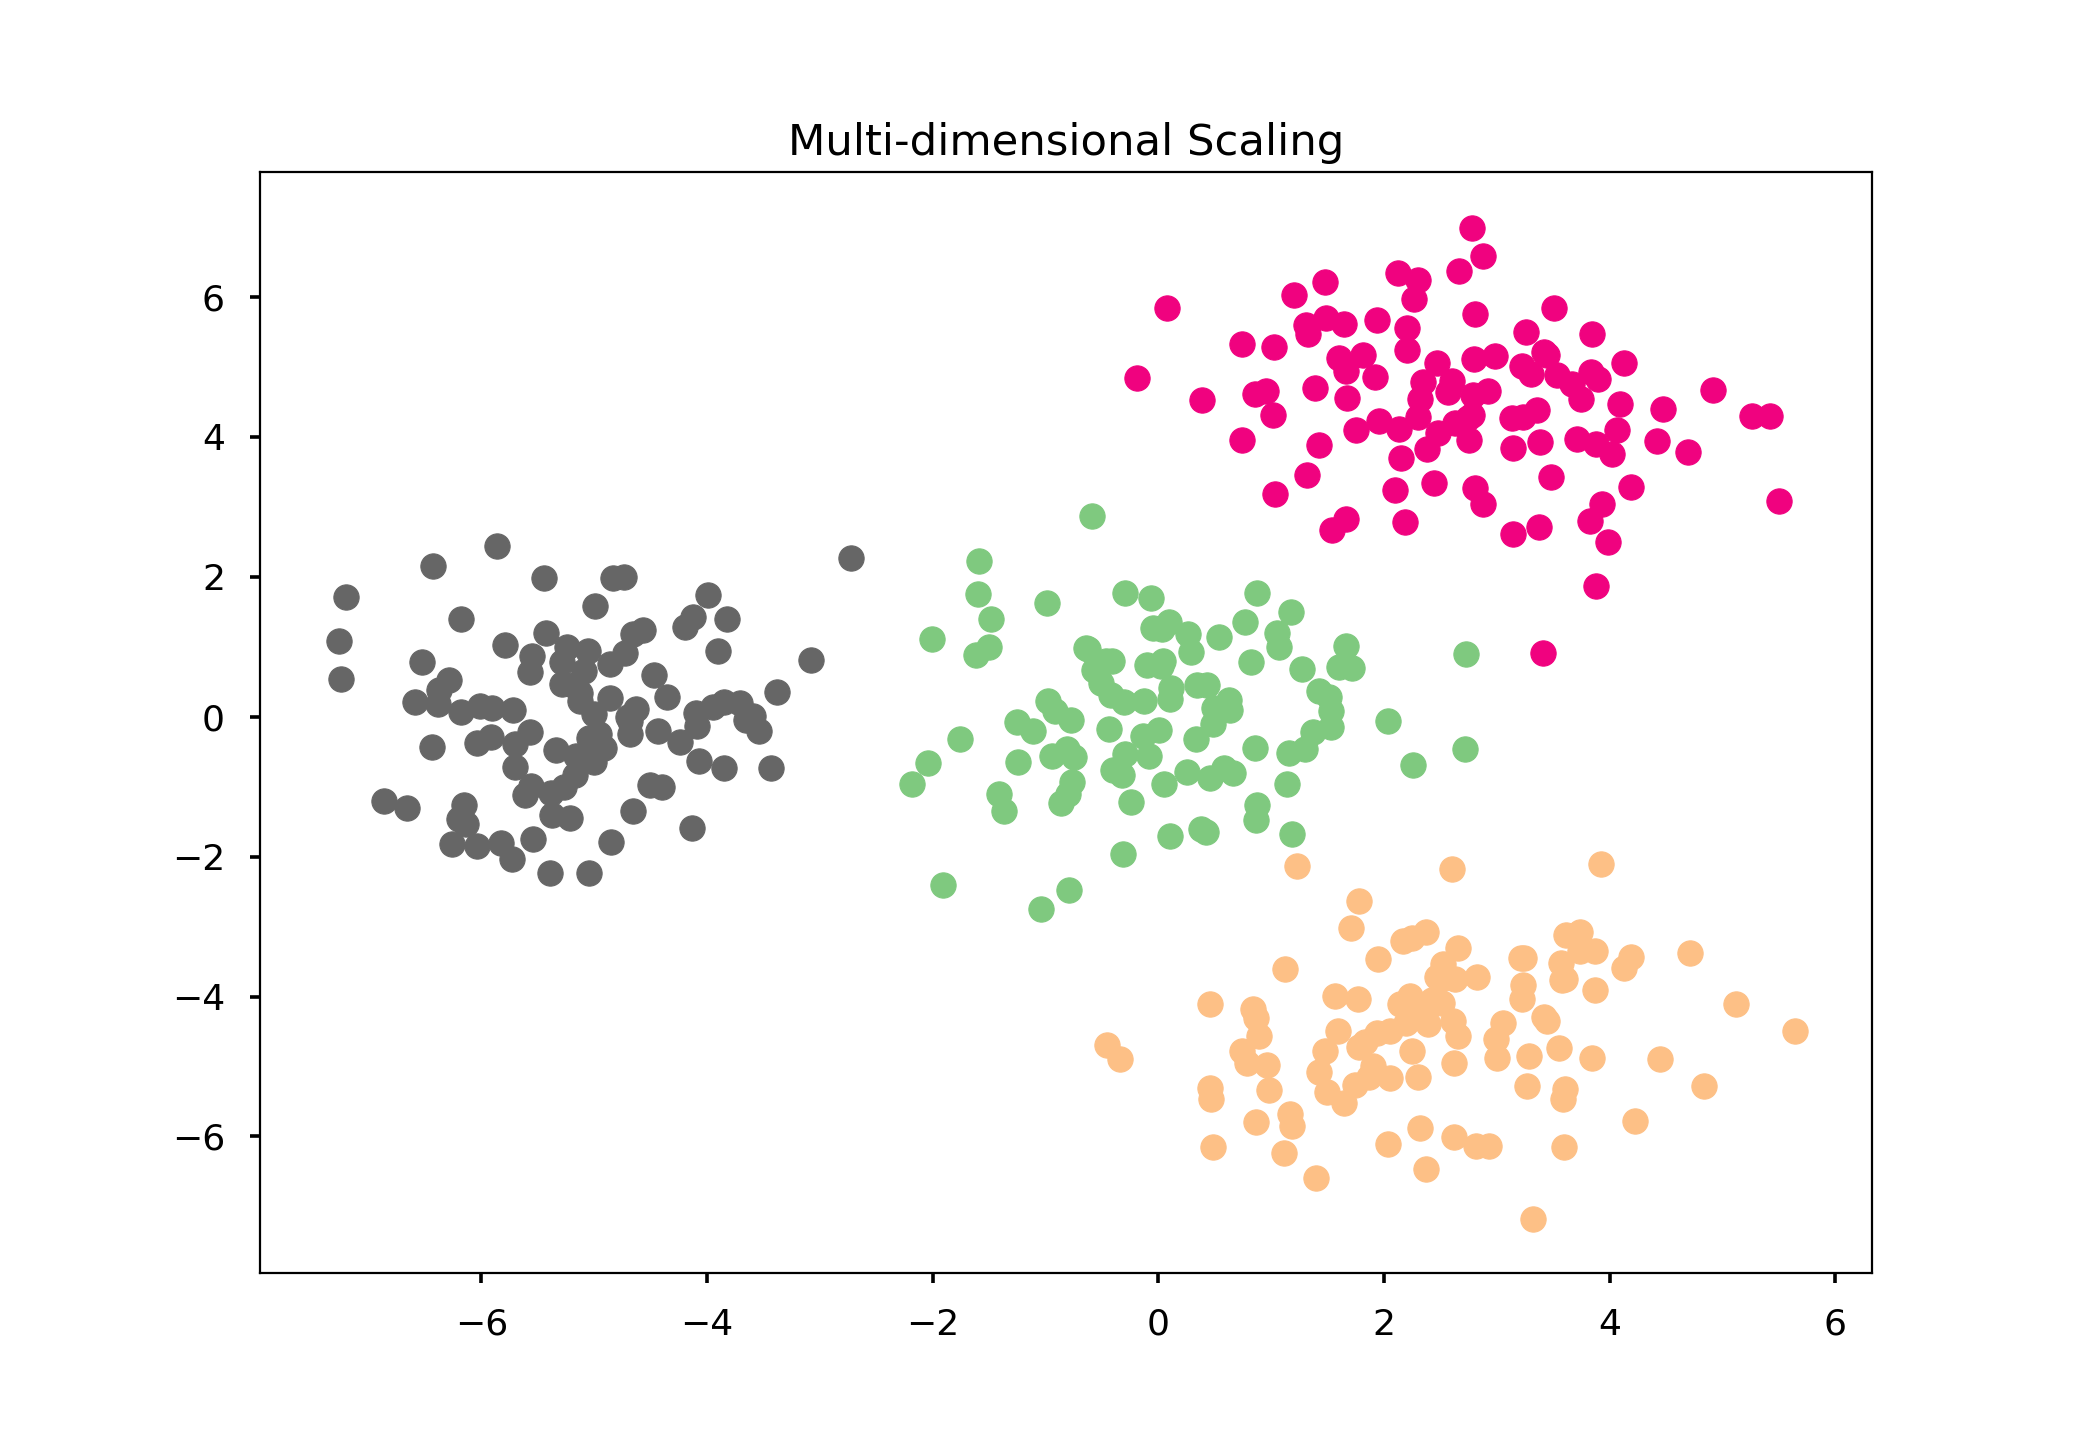

In [17]:
do_plot(MDS(n_components=2).fit_transform(X), 'Multi-dimensional Scaling')

## t-SNE (2D)

<IPython.core.display.Javascript object>


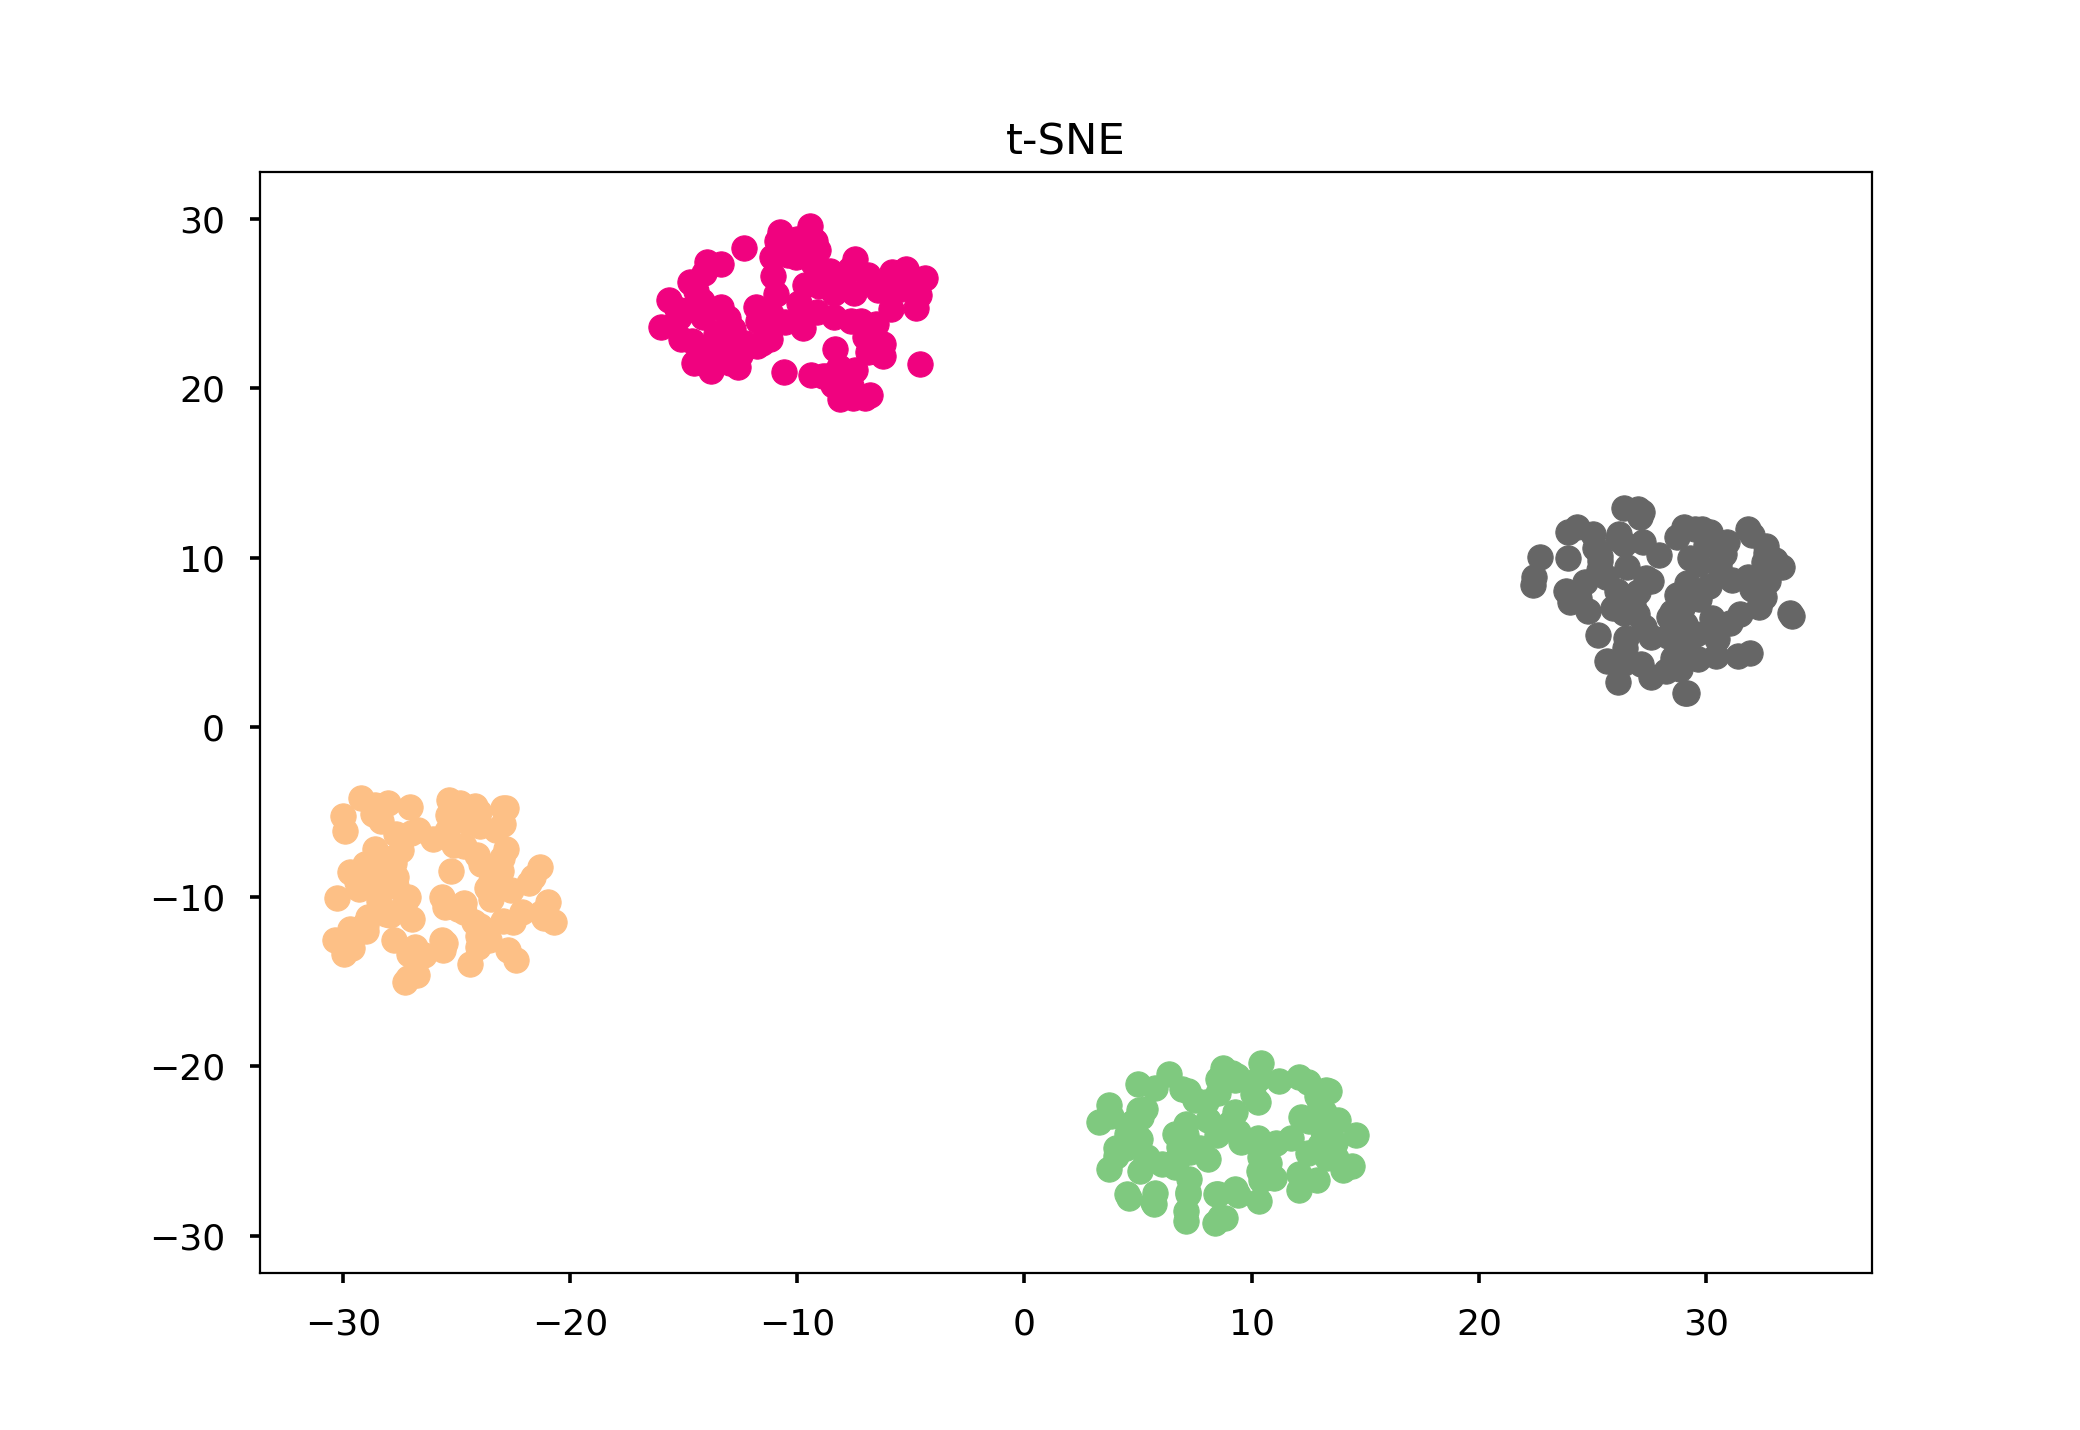

In [18]:
tsne2 = TSNE(n_components=2, random_state=0)
do_plot(tsne2.fit_transform(X), 't-SNE')

## PCA (3D)

<IPython.core.display.Javascript object>


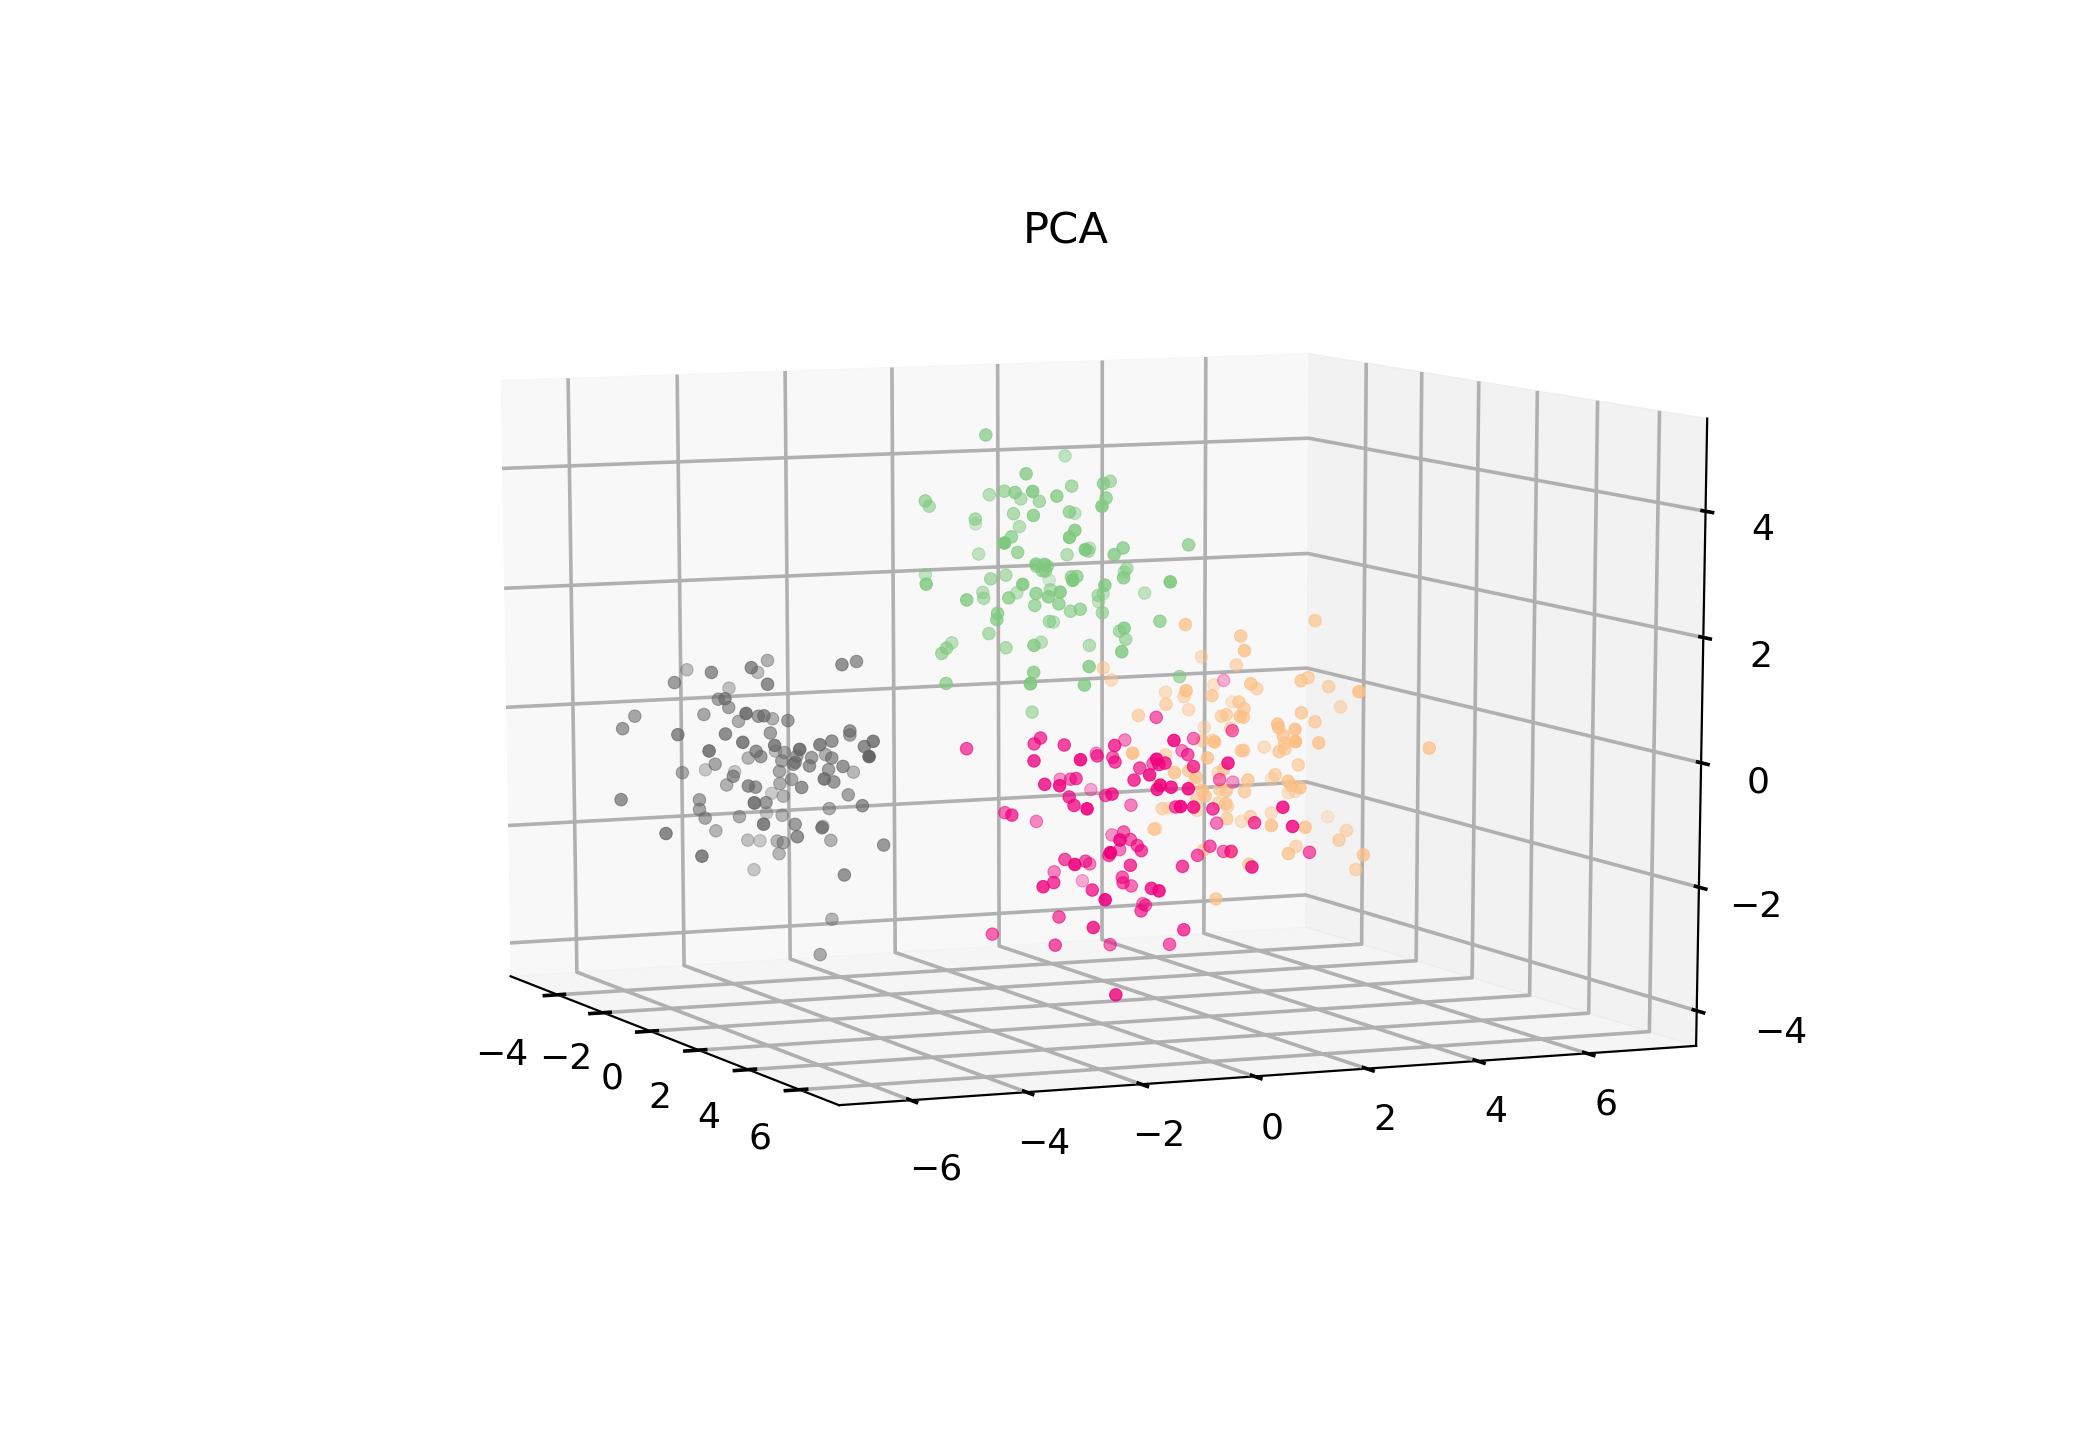

In [19]:
do_plot(PCA(n_components=3).fit_transform(X), 'PCA')

## t-SNE (3D)

<IPython.core.display.Javascript object>


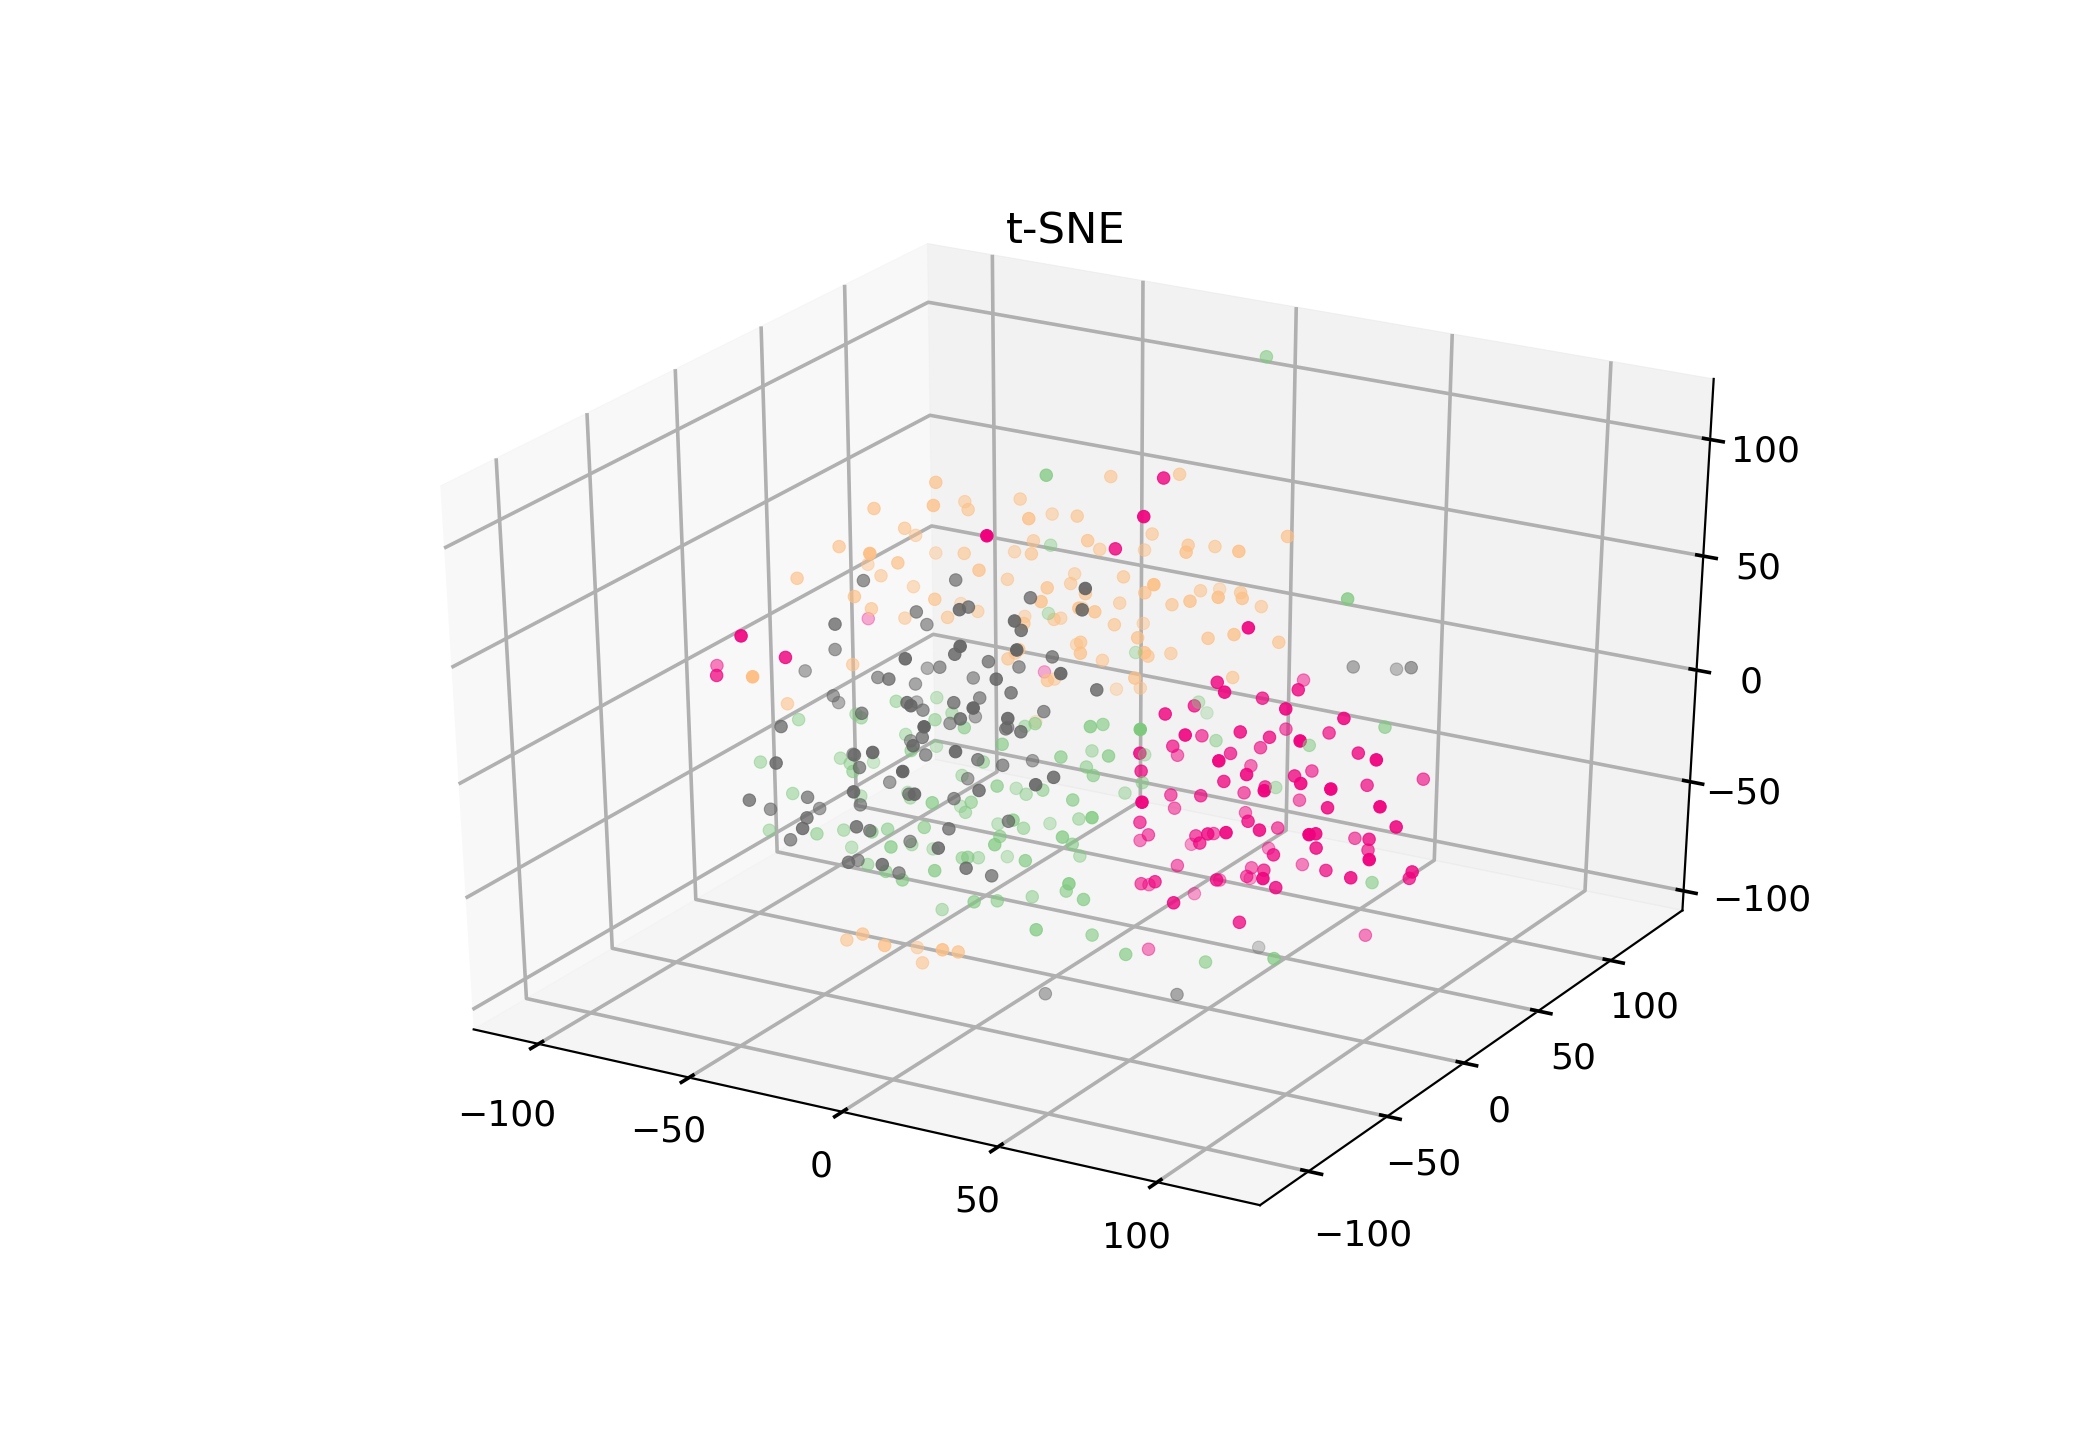

In [20]:
tsne3 = TSNE(n_components=3, learning_rate=100, random_state=0)
do_plot(tsne3.fit_transform(X), 't-SNE')

## HDBScan
HDBScan is a fairly recent and well-regarded clustering algorithm. The reason it's here is to see how well it does on some fairly simple data and visualize its results via t-SNE.

In [21]:
if hdbscan_available:
    clusterer = hdbscan.HDBSCAN(min_cluster_size=20)
    cluster_labels = clusterer.fit_predict(X_std) + 1
    print('Number of clusters: {}'.format(max(cluster_labels)))
    do_plot(tsne3.fit_transform(X), 'HDBScan', labels=cluster_labels)